# Import packages


In [1]:
import numpy as np
import pylab as pl
from numpy import fft
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from dateutil.relativedelta import relativedelta
import math
import matplotlib.dates as mdates

# Load data


In [2]:
def load_data(stock_name, date_predict_start, data_range, slide_range, n_slide):
    train_data = {}
    test_data = {}
    date_predict_start = datetime.datetime.strptime(
        date_predict_start, '%Y-%m-%d')
    date_data_start_list = []
    date_predict_start_list = []
    date_predict_end_list = []
    test_data_start_list = []
    all_data = yf.Ticker(stock_name).history(period='max')

    check = date_predict_start in list(all_data.index)
    while (check == False):
        date_predict_start = date_predict_start + \
            relativedelta(days=+1)
        check = date_predict_start in list(all_data.index)

    predict_start = all_data.index.get_loc(date_predict_start)
    for i in range(n_slide):
        predict_end = predict_start + data_range
        date_predict_end = all_data.iloc[predict_end].name
        data_start = predict_start - data_range
        date_data_start = all_data.iloc[data_start].name
        train_data['data_' + str(i)] = all_data.iloc[data_start:predict_start]
        test_data['data_' + str(i)] = all_data.iloc[predict_start:predict_end]
        date_data_start_list.append(date_data_start)
        date_predict_start_list.append(date_predict_start)
        date_predict_end_list.append(date_predict_end)
        test_data_start_list.append(datetime.datetime.strftime(
            test_data['data_' + str(i)].index[0], '%Y-%m-%d'))
        data_start = data_start + slide_range
        predict_start = predict_start + slide_range
        train_data['data_' + str(i)] = train_data['data_' +
                                                  str(i)].reset_index(drop=False)
        test_data['data_' + str(i)] = test_data['data_' +
                                                str(i)].reset_index(drop=False)

    return train_data, test_data, all_data, test_data_start_list


In [3]:
# stock_name = "^GSPC"
# date_predict_start = '2021-01-01'
# data_range = 10
# slide_range = 5
# n_slide = 3
# pv_range = 2
# n_harm_lower_limit = 3
# n_harm_upper_limit = 3
# fit_method = 'rmse'
# pv_method = 'HL'
# date_data_start_list = []
# date_predict_start_list = []
# date_predict_end_list = []
# train_data = {}
# test_data = {}
# date_predict_start = datetime.datetime.strptime(date_predict_start, '%Y-%m-%d')
# all_data = yf.Ticker(stock_name).history(period='max')

# check = date_predict_start in list(all_data.index)
# while (check == False) :
#     date_predict_start = date_predict_start + \
#         relativedelta(days=+1)
#     print(check)
#     check = date_predict_start in list(all_data.index)
# print(check)
# print(date_predict_start)
# predict_start = all_data.index.get_loc(date_predict_start)
# for i in range(n_slide):
#     predict_end = predict_start + data_range
#     date_predict_end = all_data.iloc[predict_end].name
#     data_start = predict_start - data_range
#     date_data_start = all_data.iloc[data_start].name
#     train_data['data_' + str(i)] = all_data.iloc[data_start:predict_start]
#     test_data['data_' + str(i)] = all_data.iloc[predict_start:predict_end]
#     date_data_start_list.append(date_data_start)
#     date_predict_start_list.append(date_predict_start)
#     date_predict_end_list.append(date_predict_end)
#     data_start = data_start + slide_range
#     predict_start = predict_start + slide_range


# Data preprocessing


In [4]:
def find_data_pv_CL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    for i in data:
        price = data[i]['Close']
        data[i]['peaks'] = pd.Series(dtype='float64')
        data[i]['valleys'] = pd.Series(dtype='float64')
        data[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(price)):
            if idx < pv_range:
                if price[idx] == price.iloc[0:pv_range*2+1].max():
                    data[i]['peaks'].iloc[idx] = price[idx]
                    data[i]['pv'].iloc[idx] = 'peaks'
                if price[idx] == price.iloc[0:pv_range*2+1].min():
                    data[i]['valleys'].iloc[idx] = price[idx]
                    data[i]['pv'].iloc[idx] = 'valleys'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
                data[i]['peaks'].iloc[idx] = price[idx]
                data[i]['pv'].iloc[idx] = 'peaks'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
                data[i]['valleys'].iloc[idx] = price[idx]
                data[i]['pv'].iloc[idx] = 'valleys'


In [5]:
def find_data_pv_HL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    for i in data:
        high = data[i]['High']
        low = data[i]['Low']
        data[i]['peaks'] = pd.Series(dtype='float64')
        data[i]['valleys'] = pd.Series(dtype='float64')
        data[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(high)):
            if idx < pv_range:
                if high[idx] == high.iloc[0:pv_range*2+1].max():
                    data[i]['peaks'].iloc[idx] = high[idx]
                    data[i]['pv'].iloc[idx] = 'peaks'
                if low[idx] == low.iloc[0:pv_range*2+1].min():
                    data[i]['valleys'].iloc[idx] = low[idx]
                    data[i]['pv'].iloc[idx] = 'valleys'
            if high[idx] == high.iloc[idx-pv_range:idx+pv_range].max():
                data[i]['peaks'].iloc[idx] = high[idx]
                data[i]['pv'].iloc[idx] = 'peaks'
            if low[idx] == low.iloc[idx-pv_range:idx+pv_range].min():
                data[i]['valleys'].iloc[idx] = low[idx]
                data[i]['pv'].iloc[idx] = 'valleys'


In [6]:
def preprocessing(train_data, test_data, pv_range, pv_method):
    if pv_method == 'CL':
        find_data_pv_CL_function(train_data, pv_range)
        find_data_pv_CL_function(test_data, pv_range)
    elif pv_method == 'HL':
        find_data_pv_HL_function(train_data, pv_range)
        find_data_pv_HL_function(test_data, pv_range)


# Built Model


In [7]:
def data_to_poly_function(data_stock):
    harmonics = {}
    for i in data_stock:
        harmonics[i] = {}
        data = data_stock[i]['Close']
        array_data = np.array(data)
        n_data = array_data.size
        time_data = np.arange(0, n_data)
        poly = np.zeros_like(array_data)
        # fig, axes = plt.subplots(n_data, 1, figsize=(15, n_data*3))
        # axes[0].plot(data)
        for j in range(0, n_data):
            Polynomial = np.polyfit(time_data, array_data, j)
            for k in range(0, j):
                poly += Polynomial[k] * time_data**(j-k)
            harmonics[i][j] = np.tile(poly, 2)
            # axes[j].plot(poly)
    # plt.show()
    return harmonics


In [8]:
def poly_function(harmonics, n_harm_lower_limit, n_harm_upper_limit):
    processed_signal = {}
    for i in harmonics:
        processed_signal[i] = {}
        for n_harm in range(n_harm_lower_limit, n_harm_upper_limit+1):
            processed_signal[i][n_harm] = pd.DataFrame(
                {'Close': harmonics[i][n_harm]})
    return processed_signal


# Built Model


Get signal


In [9]:
def data_to_harmonics_function(data_stock, data_range):
    harmonics = {}
    for i in data_stock:
        harmonics[i] = {}
        # get data_stock's infomation
        data = data_stock[i]['Close']
        array_data = np.array(data)
        n_data = array_data.size
        time_data = np.arange(0, n_data)

        # detrend data
        # find linear trend in data
        Polynomial = np.polyfit(time_data, array_data, 1)
        data_notrend = array_data - Polynomial[0] * time_data    # detrended x

        # fft process
        data_freqdom = fft.fft(data_notrend, n=n_data)
        frequence = fft.fftfreq(n=n_data, d=1)
        f_positive = frequence[np.where(frequence > 0)]
        data_freqdom_positive = data_freqdom[np.where(frequence > 0)]

        # sort indexes
        indexes = list(range(f_positive.size))      # frequencies
        # sort method 1
        # indexes.sort(key = lambda i: np.absolute(frequence[i]))     # sort indexes by frequency, lower -> higher
        # sort method 2 :
        # sort indexes by amplitudes, lower -> higher
        indexes.sort(key=lambda i: np.absolute(data_freqdom[i]))
        indexes.reverse()       # sort indexes by amplitudes, higher -> lower

        # get data_all_time'size
        time_transfer = np.arange(0, data_range*2)

        # mix harmonics
        for j in indexes:
            ampli = np.absolute(
                data_freqdom_positive[j]) / n_data     # amplitude
            phase = np.angle(data_freqdom_positive[j])      # phase
            harmonics[i][j] = ampli * \
                np.cos(2 * np.pi * f_positive[j] * time_transfer + phase)
    return harmonics


In [10]:
def mix_harmonics_function(harmonics, n_harm_lower_limit, n_harm_upper_limit):
    processed_signal = {}
    for i in harmonics:
        processed_signal[i] = {}
        for n_harm in range(n_harm_lower_limit, n_harm_upper_limit+1):
            mixed_harmonic = np.zeros(len(harmonics[i][0]))
            for j in range(n_harm):
                mixed_harmonic += harmonics[i][j]
            processed_signal[i][n_harm] = pd.DataFrame(
                {'Close': mixed_harmonic})
    return processed_signal


Signal processing


In [11]:
def find_signal_pv_function(signal, pv_range):
    pd.options.mode.chained_assignment = None
    for i in signal:
        for j in signal[i]:
            data = signal[i][j]['Close']
            signal[i][j]['peaks'] = pd.Series(dtype='float64')
            signal[i][j]['valleys'] = pd.Series(dtype='float64')
            signal[i][j]['pv'] = pd.Series(dtype='str')
            for idx in range(0, len(data)):
                if idx < pv_range:
                    if data[idx] == data.iloc[0:pv_range*2+1].max():
                        signal[i][j]['peaks'].iloc[idx] = data[idx]
                        signal[i][j]['pv'].iloc[idx] = 'peaks'
                    if data[idx] == data.iloc[0:pv_range*2+1].min():
                        signal[i][j]['valleys'].iloc[idx] = data[idx]
                        signal[i][j]['pv'].iloc[idx] = 'valleys'
                if data[idx] == data.iloc[idx-pv_range:idx+pv_range].max():
                    signal[i][j]['peaks'].iloc[idx] = data[idx]
                    signal[i][j]['pv'].iloc[idx] = 'peaks'
                if data[idx] == data.iloc[idx-pv_range:idx+pv_range].min():
                    signal[i][j]['valleys'].iloc[idx] = data[idx]
                    signal[i][j]['pv'].iloc[idx] = 'valleys'


In [12]:
def find_signal_lead_train_function(data, processed_signal):
    for d in data:
        for p in processed_signal[d]:
            # processed_signal[d][p]['pv'] = pd.Series(dtype='str')
            processing_signal = processed_signal[d][p].head(len(data[d]))
            p_data = pd.DataFrame(
                {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
            p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
            p_data_count = list(p_data['count'])
            p_signal = pd.DataFrame(
                {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
            p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
            p_signal_list = list(p_signal['count'])
            p_lead = []
            for i in range(0, len(p_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(p_data_count)):
                    temp.append((p_data_count[j] - p_signal_list[i]))
                    temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                p_lead.append(temp_2)
            p_signal['lead'] = p_lead

            v_data = pd.DataFrame(
                {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
            v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
            v_data_count = list(v_data['count'])
            v_signal = pd.DataFrame(
                {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
            v_signal = v_signal.drop(
                v_signal[v_signal['valleys'].isna()].index)
            v_signal_list = list(v_signal['count'])
            v_lead = []
            for i in range(0, len(v_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(v_data_count)):
                    temp.append((v_data_count[j] - v_signal_list[i]))
                    temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                v_lead.append(temp_2)
            v_signal['lead'] = v_lead

            processed_signal[d][p]['lead'] = pd.Series(dtype='float64')
            processed_signal[d][p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
            processed_signal[d][p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']


In [13]:
def build_model(train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range):
    # harmonics = data_to_poly_function(train_data)
    # processed_signal = poly_function(harmonics, n_harm_lower_limit, n_harm_upper_limit)
    harmonics = data_to_harmonics_function(train_data, data_range)
    processed_signal = mix_harmonics_function(
        harmonics, n_harm_lower_limit, n_harm_upper_limit)
    find_signal_pv_function(processed_signal, pv_range)
    find_signal_lead_train_function(train_data, processed_signal)
    return harmonics, processed_signal


# Select model


In [48]:
def get_fit_error_function(processed_signal, fit_method):
    errors = {}
    error = []
    for i in processed_signal:
        errors[i] = {}
        for j in processed_signal[i]:
            signal_dropna = processed_signal[i][j].drop(
                processed_signal[i][j][processed_signal[i][j]['lead'].isna()].index)
            if fit_method == 'mean':
                error = signal_dropna['lead'].mean()
                signal_dropna = processed_signal['data_0'][j].drop(
                    processed_signal[i][j][processed_signal[i][j]['lead'].isna()].index)
                print(signal_dropna['lead'])
            elif fit_method == 'abs':
                error = abs(signal_dropna['lead']).mean()
            elif fit_method == 'rmse':
                mse = np.square(np.subtract(np.zeros_like(
                    signal_dropna['lead']), signal_dropna['lead'])).mean()
                rmse = math.sqrt(mse)
                error = rmse
            errors[i][j] = error
    return errors


In [39]:
def get_best_fit_harm_function(processed_signal, errors):
    best_error = {}
    best_fit_harm = {}
    for i in processed_signal:
        try :
            best_error[i] = np.abs(pd.Series(errors[i])).min()
            best_fit_harm[i] = pd.Series(errors[i]).abs().idxmin()
        except :
            print('i = ', i)
            # print('processed_signal[i] = ', processed_signal[i])
            print('errors[i] = ', errors[i])
    return best_fit_harm, best_error


In [16]:
def find_signal_lead_test_function(data, processed_signal):
    for d in data:
        for p in processed_signal[d]:
            processed_signal[d][p]['pv'] = pd.Series(dtype='str')
            processing_signal = processed_signal[d][p].tail(len(data[d]))
            p_data = pd.DataFrame(
                {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
            p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
            p_data_count = list(p_data['count'])
            p_signal = pd.DataFrame(
                {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
            p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
            p_signal_list = list(p_signal['count'])
            p_lead = []
            for i in range(0, len(p_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(p_data_count)):
                    temp.append((p_data_count[j] - p_signal_list[i]))
                    temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                p_lead.append(temp_2)
            p_signal['lead'] = p_lead

            v_data = pd.DataFrame(
                {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
            v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
            v_data_count = list(v_data['count'])
            v_signal = pd.DataFrame(
                {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
            v_signal = v_signal.drop(
                v_signal[v_signal['valleys'].isna()].index)
            v_signal_list = list(v_signal['count'])
            v_lead = []
            for i in range(0, len(v_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(v_data_count)):
                    temp.append((v_data_count[j] - v_signal_list[i]))
                    temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                v_lead.append(temp_2)
            v_signal['lead'] = v_lead

            processed_signal[d][p]['lead'] = pd.Series(dtype='float64')
            processed_signal[d][p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
            processed_signal[d][p]['pv'].loc[p_signal['lead'].index] = 'peak'
            processed_signal[d][p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']
            processed_signal[d][p]['pv'].loc[v_signal['lead'].index] = 'valley'


In [17]:
def get_first_lead_function(processed_signal, best_fit_harm):
    first_date = {}
    lead = {}
    pv = {}
    for i in processed_signal:
        harm = best_fit_harm[i]
        temp = processed_signal[i][harm].loc[list(
            processed_signal[i][harm]['lead'].dropna().index)[0]]
        first_date[i] = list(processed_signal[i][harm]
                             ['lead'].dropna().index)[0]
        lead[i] = temp['lead']
        pv[i] = temp['pv']
    return first_date, lead, pv


In [18]:
def select_model(test_data, processed_signal, fit_method):
    errors = get_fit_error_function(processed_signal, fit_method)
    best_fit_harm, best_error = get_best_fit_harm_function(
        processed_signal, errors)
    find_signal_lead_test_function(test_data, processed_signal)
    first_date, lead, pv = get_first_lead_function(
        processed_signal, best_fit_harm)
    return errors, best_fit_harm, best_error, first_date, lead, pv


# Evaluate model


In [19]:
def built_result_table_function(processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm):
    result_table = pd.DataFrame(columns=[
        's_date', 't_date', 'lead', 'ans_date', 'pv', 'error', 'best_fit'])
    for i in processed_signal:
        result_table.loc[i, 'error'] = round(best_error[i], 2)
        result_table.loc[i, 'best_fit'] = best_fit_harm[i]
        result_table.loc[i, 'lead'] = lead[i]
        result_table.loc[i, 'pv'] = pv[i]
    result_table['s_date'] = test_data_start_list
    return result_table


In [20]:
def result_table_process_function(result_table, all_data, first_date, data_range):
    for i in result_table.index:
        t_date = all_data.iloc[all_data.index.get_loc(
            result_table.loc[i, 's_date']) + first_date[i] - data_range].name
        t_date = datetime.datetime.strftime(t_date, '%Y-%m-%d')
        result_table.loc[i, 't_date'] = t_date
        ans = all_data.iloc[int(all_data.index.get_loc(
            result_table.loc[i, 't_date']) + result_table.loc[i, 'lead'])].name
        ans = datetime.datetime.strftime(ans, '%Y-%m-%d')
        result_table.loc[i, 'ans_date'] = ans


In [21]:
def compute_final_error_function(result_table):
    final_error = round(
        sum([abs(ele) for ele in result_table['lead']]) / len(result_table['lead']), 2)
    return final_error


In [22]:
def evaluate_model(processed_signal, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range):
    result_table = built_result_table_function(
        processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)
    result_table_process_function(
        result_table, all_data, first_date, data_range)
    final_error = compute_final_error_function(result_table)
    return result_table, final_error


# Draw plot


In [23]:
def find_data_pv_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    price = data['Close']
    data['peaks'] = pd.Series(dtype='float64')
    data['valleys'] = pd.Series(dtype='float64')
    data['pv'] = pd.Series(dtype='str')
    for idx in range(0, len(price)):
        if idx < pv_range:
            if price[idx] == price.iloc[0:pv_range*2+1].max():
                data['peaks'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'peaks'
            if price[idx] == price.iloc[0:pv_range*2+1].min():
                data['valleys'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'valleys'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
            data['peaks'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'peaks'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
            data['valleys'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'valleys'


In [24]:
# def draw_plot_result_table(all_data, result_table, pv_range):
#     date_list = sorted(
#         list(result_table['s_date']) + list(result_table['t_date']) + list(result_table['ans_date']))
#     plot_data = all_data.loc[date_list[0]:date_list[-1]]
#     result_table.index = result_table['t_date']
#     plot_model = pd.DataFrame(index=plot_data.index, columns=[
#                               's_date', 't_date', 'ans_date', 'lead', 'pv'])
#     plot_model['s_date'].loc[result_table['s_date']] = True
#     plot_model['t_date'].loc[result_table['t_date']] = True
#     plot_model['lead'].loc[result_table['t_date']] = list(result_table['lead'])
#     plot_model['pv'].loc[result_table['t_date']] = list(result_table['pv'])
#     plot_model['ans_date'].loc[result_table['ans_date']] = 1
#     find_data_pv_function(plot_data, pv_range)
#     fig, axes = plt.subplots(2, 1, figsize=(30, 8), sharex=True)
#     axes[0].plot(plot_data.index, plot_data['Close'],
#                  'gray', label='data', linewidth=3)
#     # axes[0].plot(plot_data.index, plot_data['ans_date'], '|', c='red', label='ans')
#     axes[0].plot(plot_data.index, plot_data['peaks'],
#                  '^', c='royalblue', label='peaks')
#     axes[0].plot(plot_data.index, plot_data['valleys'], 'v',
#                  c='orangered', label='valleys')
#     print(plot_data)

#     for i, label in enumerate(plot_model['ans_date']):
#         if plot_model['ans_date'][i] == 1:
#             print(plot_data.index[i])
#             axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
#                          c='red')
#             # axes[1].plot(plot_model.index[i], plot_model['lead'][i], '^',
#             #             c='royalblue')
#             # text = str(label)
#             # axes[1].annotate(text, (plot_model.index[i], plot_model['lead'][i]), fontsize=14)

#         # elif plot_model['pv'][i] == 'valley':
#         #     axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
#         #                 c='red')
#         #     axes[1].plot(plot_model.index[i], plot_model['lead'][i], 'v',
#         #                 c='orangered')
#         #     text = str(label)
#         #     axes[1].annotate(text, (plot_model.index[i], plot_model['lead'][i]), fontsize=14)

#     for i, label in enumerate(plot_model['lead']):
#         if plot_model['pv'][i] == 'peak':
#             # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
#             #             c='red')
#             axes[1].plot(plot_model.index[i], plot_model['lead'][i], '^',
#                          c='royalblue')
#             text = str(label)
#             axes[1].annotate(text, (plot_model.index[i],
#                              plot_model['lead'][i]), fontsize=14)
#         elif plot_model['pv'][i] == 'valley':
#             # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
#             #             c='red')
#             axes[1].plot(plot_model.index[i], plot_model['lead'][i], 'v',
#                          c='orangered')
#             text = str(label)
#             axes[1].annotate(text, (plot_model.index[i],
#                              plot_model['lead'][i]), fontsize=14)
#     axes[0].set_ylabel("Stock price", fontsize=14)
#     axes[0].grid(True)
#     axes[1].grid(True)
#     axes[0].legend()
#     axes[1].set_ylabel("lead", fontsize=14)
#     plt.show()


In [25]:
def draw_plot_result_table(test_data, all_data, result_table, pv_range):
    date_list = sorted(
        list(result_table['s_date']) + list(result_table['t_date']) + list(result_table['ans_date']))
    all_index = all_data.loc[date_list[0]:date_list[-1]].index
    fig, axes = plt.subplots(2, 1, figsize=(30, 8), sharex=True)
    for d in test_data :
        test_data[d].index = test_data[d]['Date']
        test_data[d]= test_data[d].drop(test_data[d][test_data[d].index > date_list[-1]].index)
        axes[0].plot(test_data[d].index, test_data[d]['Close'], 'gray', label='data', linewidth=3)
    for d in test_data :
        axes[0].plot(test_data[d].index, test_data[d]['peaks'],
                    '^', c='royalblue', label='peaks')
        axes[0].plot(test_data[d].index, test_data[d]['valleys'], 'v',
                    c='orangered', label='valleys')
    plot_model = pd.DataFrame(index=all_index, columns=[
                                's_date', 't_date', 'ans_date', 'lead', 'pv'])
    plot_model['s_date'].loc[result_table['s_date']] = True
    plot_model['t_date'].loc[result_table['t_date']] = True
    plot_model['lead'].loc[result_table['t_date']] = list(result_table['lead'])
    plot_model['pv'].loc[result_table['t_date']] = list(result_table['pv'])
    plot_model['ans_date'].loc[result_table['ans_date']] = True
    for i, label in enumerate(plot_model['lead']):
        if plot_model['pv'][i] == 'peak':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], '^',
                            c='royalblue')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)
        elif plot_model['pv'][i] == 'valley':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], 'v',
                            c='orangered')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)

    axes[0].set_ylabel("Stock price", fontsize=14)
    axes[0].grid(True)
    axes[1].grid(True)
    axes[1].set_ylabel("lead", fontsize=14)
    plt.show()

# Main function


In [26]:
def main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
        n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method):

    # 1. Load data
    train_data, test_data, all_data, test_data_start_list = load_data(
        stock_name, date_predict_start, data_range, slide_range, n_slide)
    # 2. Preprocessing
    preprocessing(train_data, test_data, pv_range, pv_method)
    # 3. Build model
    harmonics, model = build_model(
        train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range)
    # 4. Select model
    errors, best_fit_harm, best_error, first_date, lead, pv = select_model(test_data,
                                                                           model, fit_method)
    # 5. Evaluate model
    result_table, final_error = evaluate_model(
        model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
    print('final_error = ', final_error)
    with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
        print(result_table)
    draw_plot_result_table(test_data, all_data, result_table, pv_range)
    return harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error


final_error =  1.97
             s_date      t_date lead    ans_date      pv error best_fit
data_0   2019-06-03  2019-06-03  5.0  2019-06-10    peak  0.25       22
data_1   2019-06-17  2019-06-17  0.0  2019-06-17  valley  0.17       19
data_2   2019-07-01  2019-07-02 -1.0  2019-07-01  valley  0.15       23
data_3   2019-07-16  2019-07-16  0.0  2019-07-16    peak  0.07       23
data_4   2019-07-30  2019-07-30  0.0  2019-07-30    peak   0.4       24
data_5   2019-08-13  2019-08-13  1.0  2019-08-14  valley  0.06       23
data_6   2019-08-27  2019-08-27  0.0  2019-08-27  valley   0.0       24
data_7   2019-09-11  2019-09-11  3.0  2019-09-16  valley   0.0       24
data_8   2019-09-25  2019-09-25  0.0  2019-09-25    peak  0.05       23
data_9   2019-10-09  2019-10-24 -4.0  2019-10-18  valley   0.0        1
data_10  2019-10-23  2019-10-23  3.0  2019-10-28    peak  0.29       24
data_11  2019-11-06  2019-11-07 -1.0  2019-11-06  valley   0.5       18
data_12  2019-11-20  2019-11-22  3.0  2019-1

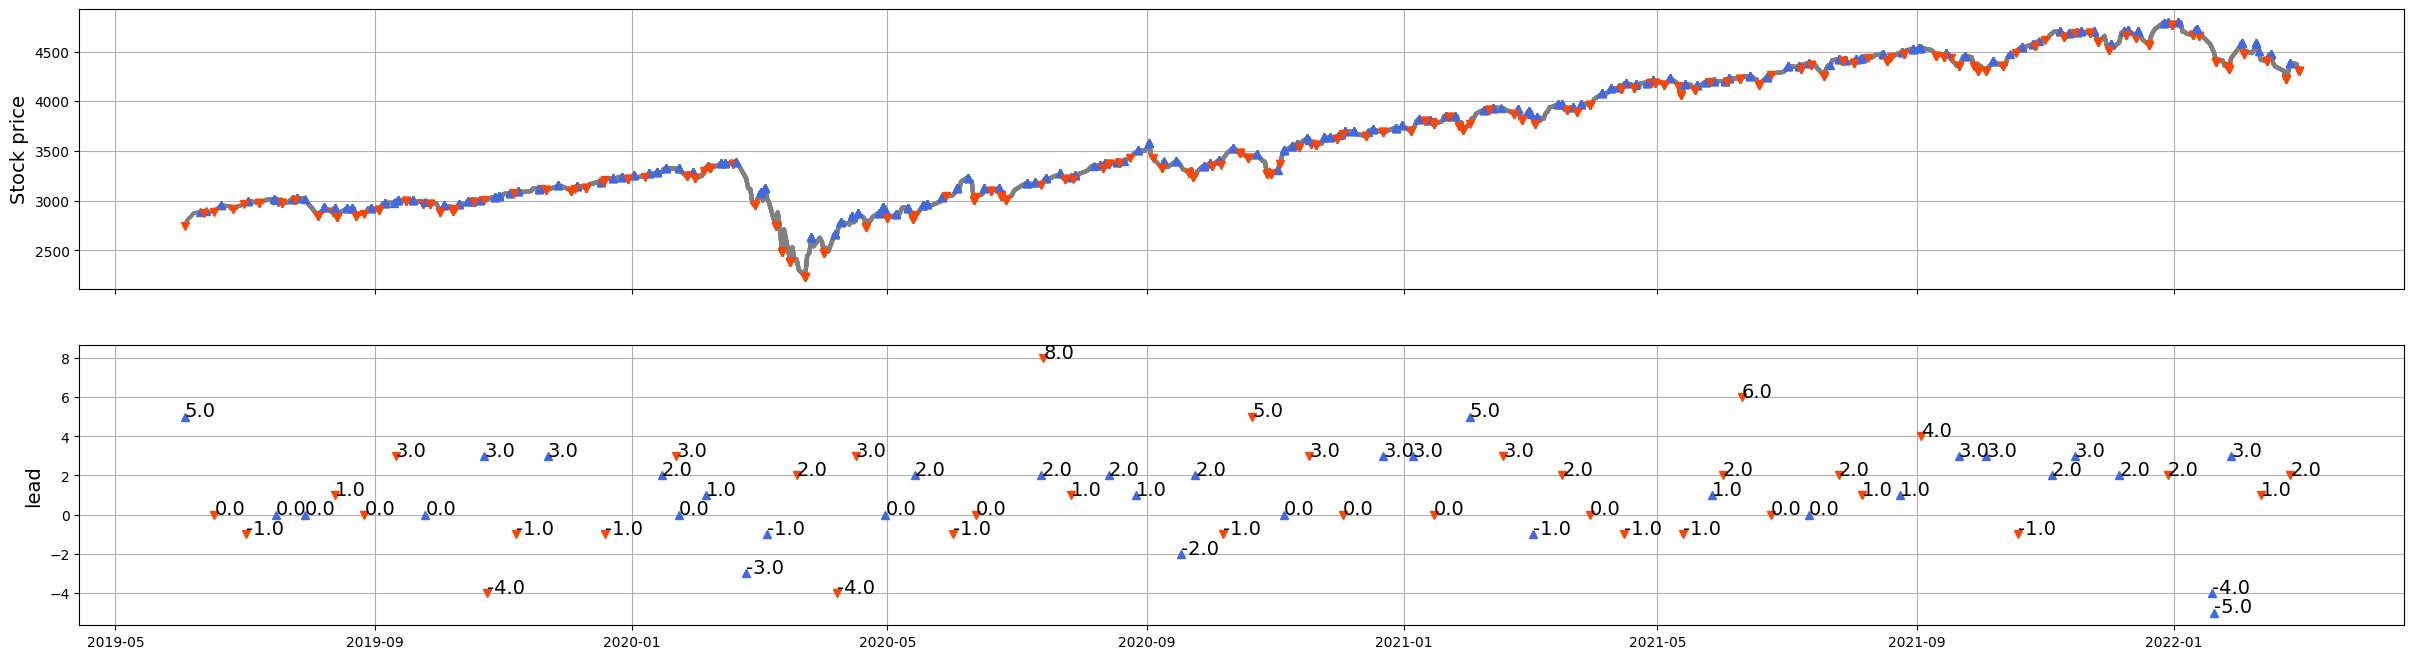

In [59]:
stock_name = "^GSPC"
date_predict_start = '2019-06-01'
data_range = 50
slide_range = 10
n_slide = 70
pv_range = 2
n_harm_lower_limit = 1
n_harm_upper_limit = 24
fit_method = 'abs'
pv_method = 'CL'
harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error = main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
    n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method)


final_error =  2.23
             s_date      t_date lead    ans_date      pv error best_fit
data_0   2019-06-03  2019-06-04  5.0  2019-06-11    peak   0.6        9
data_1   2019-06-17  2019-07-05 -1.0  2019-07-03    peak  0.33        1
data_2   2019-07-01  2019-07-02 -1.0  2019-07-01  valley  0.62        7
data_3   2019-07-16  2019-07-16  0.0  2019-07-16    peak  0.36       24
data_4   2019-07-30  2019-08-09  1.0  2019-08-12  valley  0.67        1
data_5   2019-08-13  2019-08-13  2.0  2019-08-15  valley  0.33       12
data_6   2019-08-27  2019-09-30  1.0  2019-10-01    peak   0.0        1
data_7   2019-09-11  2019-09-11  0.0  2019-09-11  valley  0.32       24
data_8   2019-09-25  2019-09-26  3.0  2019-10-01    peak  0.39       17
data_9   2019-10-09  2019-10-09  2.0  2019-10-11    peak  0.38       24
data_10  2019-10-23  2019-10-23  5.0  2019-10-30    peak  0.32       23
data_11  2019-11-06  2019-11-07 -1.0  2019-11-06  valley  0.37       17
data_12  2019-11-20  2019-11-22  3.0  2019-1

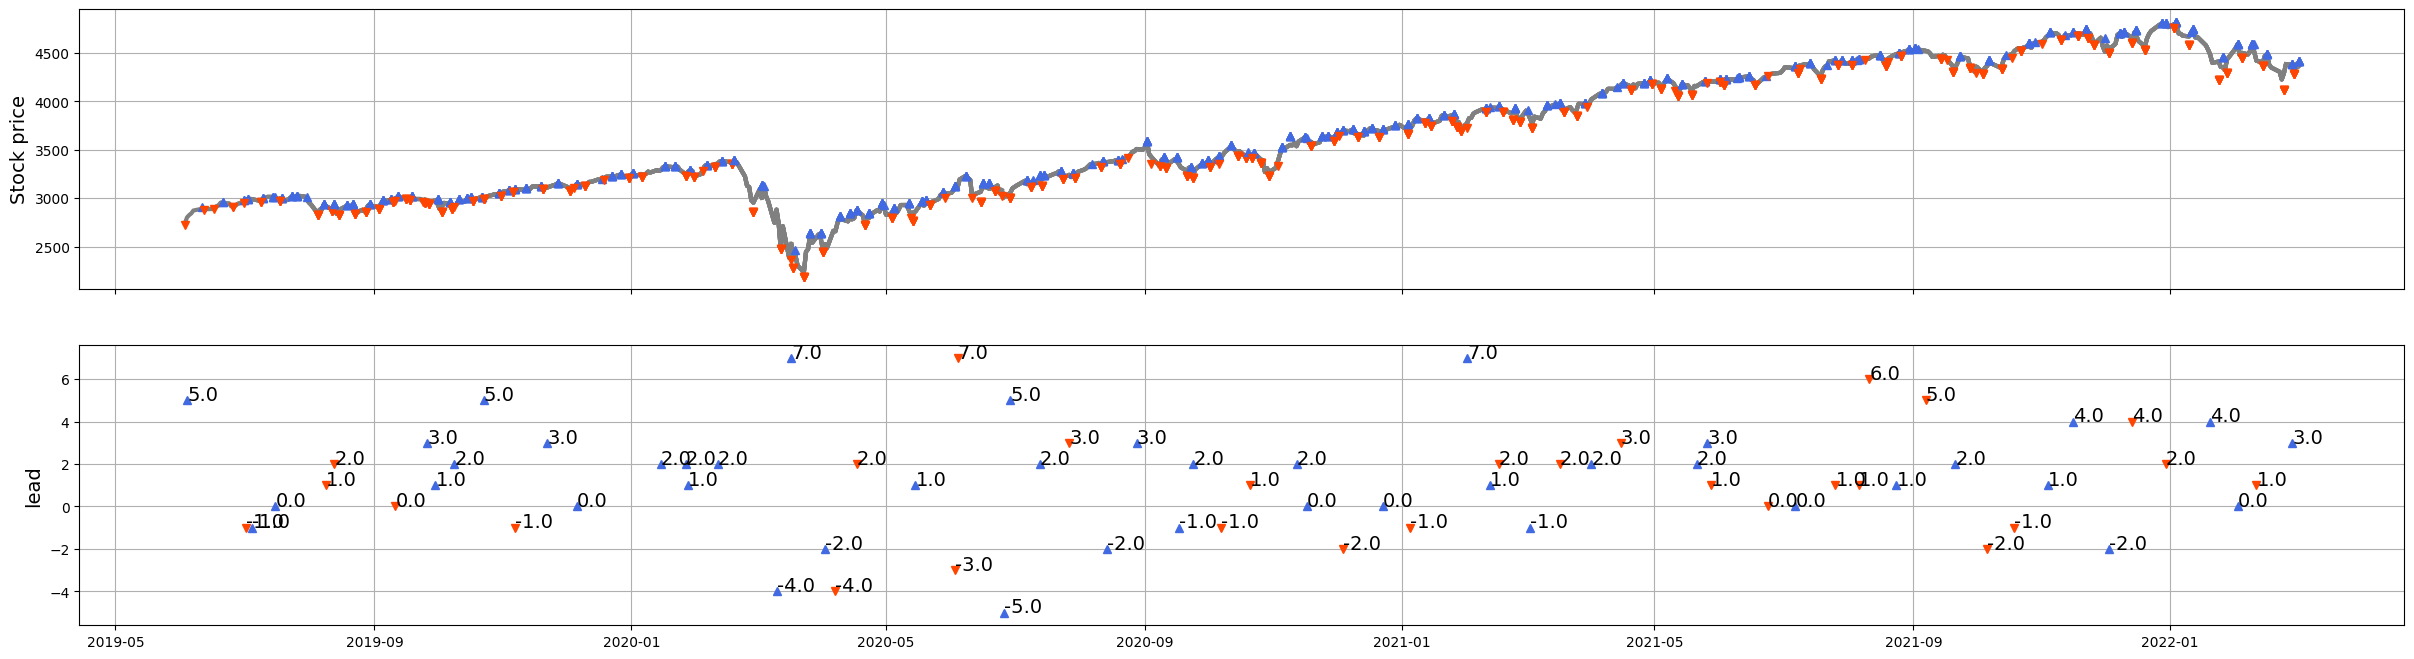

In [60]:
stock_name = "^GSPC"
date_predict_start = '2019-06-01'
data_range = 50
slide_range = 10
n_slide = 70
pv_range = 2
n_harm_lower_limit = 1
n_harm_upper_limit = 24
fit_method = 'abs'
pv_method = 'HL'
harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error = main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
    n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method)


final_error =  1.89
             s_date      t_date lead    ans_date      pv error best_fit
data_0   2019-06-03  2019-06-03  0.0  2019-06-03  valley   0.0        2
data_1   2019-06-17  2019-06-20 -3.0  2019-06-17  valley   0.0        5
data_2   2019-07-01  2019-07-03  2.0  2019-07-08  valley   0.0        8
data_3   2019-07-16  2019-08-15 -1.0  2019-08-14  valley   0.0        1
data_4   2019-07-30  2019-08-09  1.0  2019-08-12  valley   0.0        1
data_5   2019-08-13  2019-08-13  1.0  2019-08-14  valley   0.0       24
data_6   2019-08-27  2019-08-27  0.0  2019-08-27  valley   0.0       19
data_7   2019-09-11  2019-09-11  3.0  2019-09-16  valley   0.0       21
data_8   2019-09-25  2019-09-25  0.0  2019-09-25    peak   0.0        8
data_9   2019-10-09  2019-10-24 -4.0  2019-10-18  valley   0.0        1
data_10  2019-10-23  2019-11-22  3.0  2019-11-27    peak   0.0        1
data_11  2019-11-06  2019-11-08 -2.0  2019-11-06  valley   0.0        6
data_12  2019-11-20  2019-11-21  4.0  2019-1

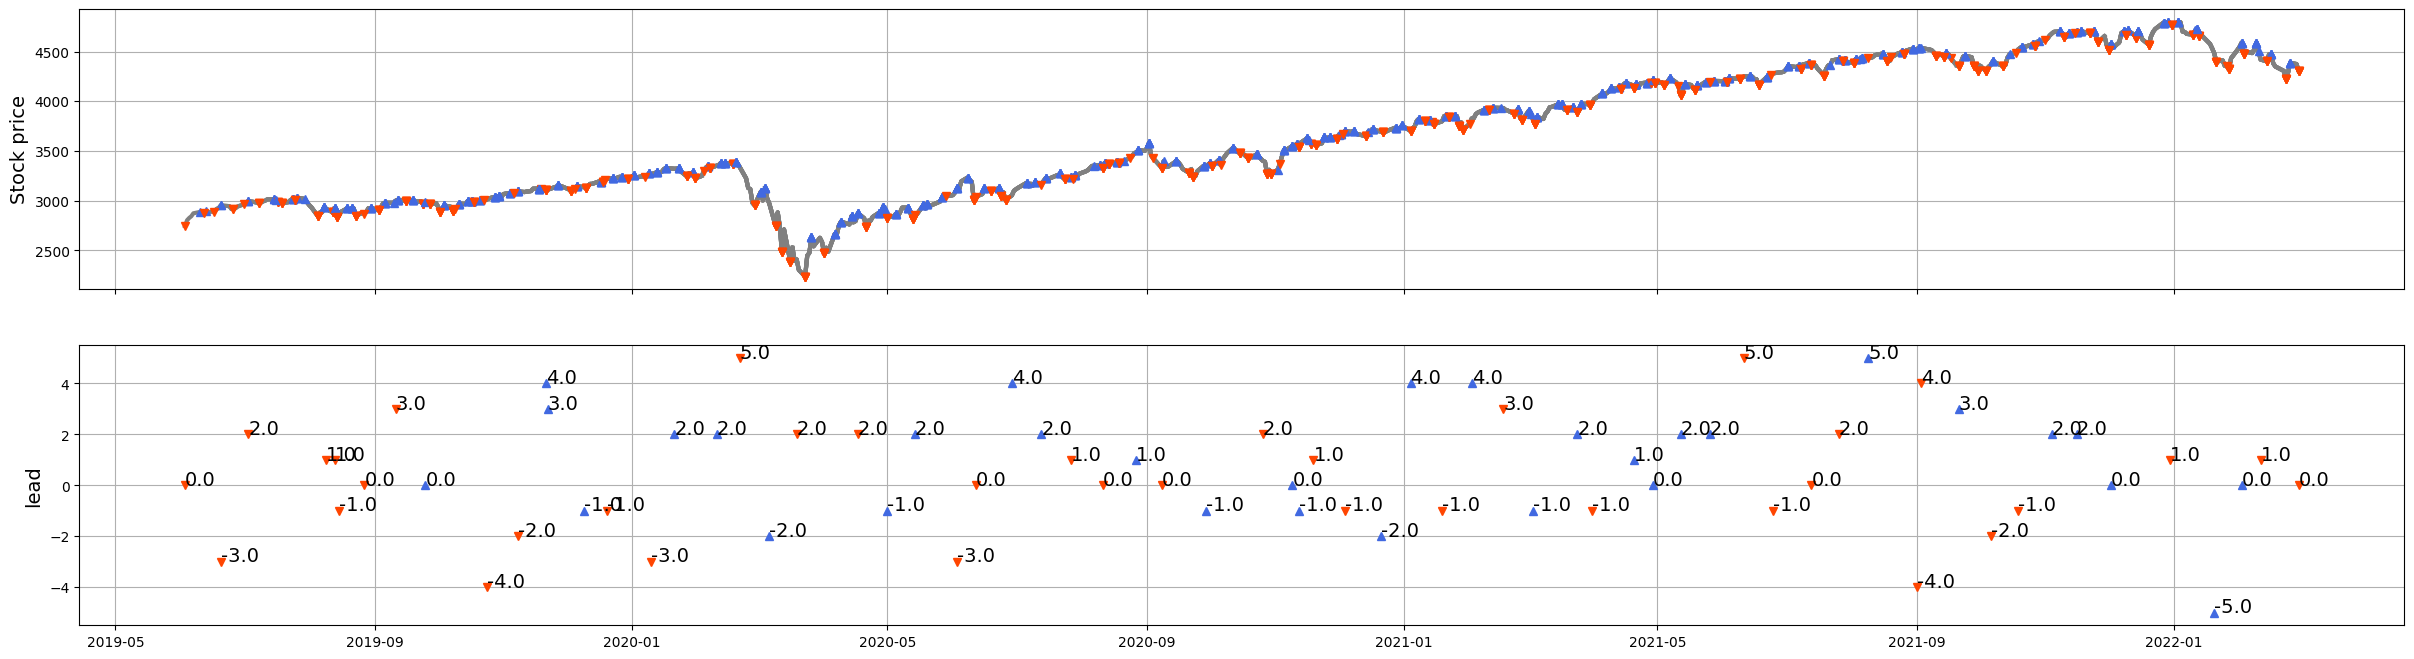

In [61]:
stock_name = "^GSPC"
date_predict_start = '2019-06-01'
data_range = 50
slide_range = 10
n_slide = 70
pv_range = 2
n_harm_lower_limit = 1
n_harm_upper_limit = 24
fit_method = 'mean'
pv_method = 'CL'
harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error = main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
    n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method)


final_error =  1.86
             s_date      t_date lead    ans_date      pv error best_fit
data_0   2019-06-03  2019-06-03  0.0  2019-06-03  valley   0.0        4
data_1   2019-06-17  2019-06-25  1.0  2019-06-26  valley   0.0        3
data_2   2019-07-01  2019-07-02 -1.0  2019-07-01  valley   0.0       23
data_3   2019-07-16  2019-07-17 -1.0  2019-07-16    peak   0.0        8
data_4   2019-07-30  2019-08-14  1.0  2019-08-15  valley   0.2        2
data_5   2019-08-13  2019-08-13  2.0  2019-08-15  valley  0.15       13
data_6   2019-08-27  2019-09-30  1.0  2019-10-01    peak   0.0        1
data_7   2019-09-11  2019-09-12 -1.0  2019-09-11  valley   0.0       20
data_8   2019-09-25  2019-09-26  3.0  2019-10-01    peak   0.0       11
data_9   2019-10-09  2019-10-11  0.0  2019-10-11    peak   0.0        5
data_10  2019-10-23  2019-10-24 -1.0  2019-10-23  valley   0.0        5
data_11  2019-11-06  2019-11-08 -2.0  2019-11-06  valley  0.14        6
data_12  2019-11-20  2019-12-23  5.0  2019-1

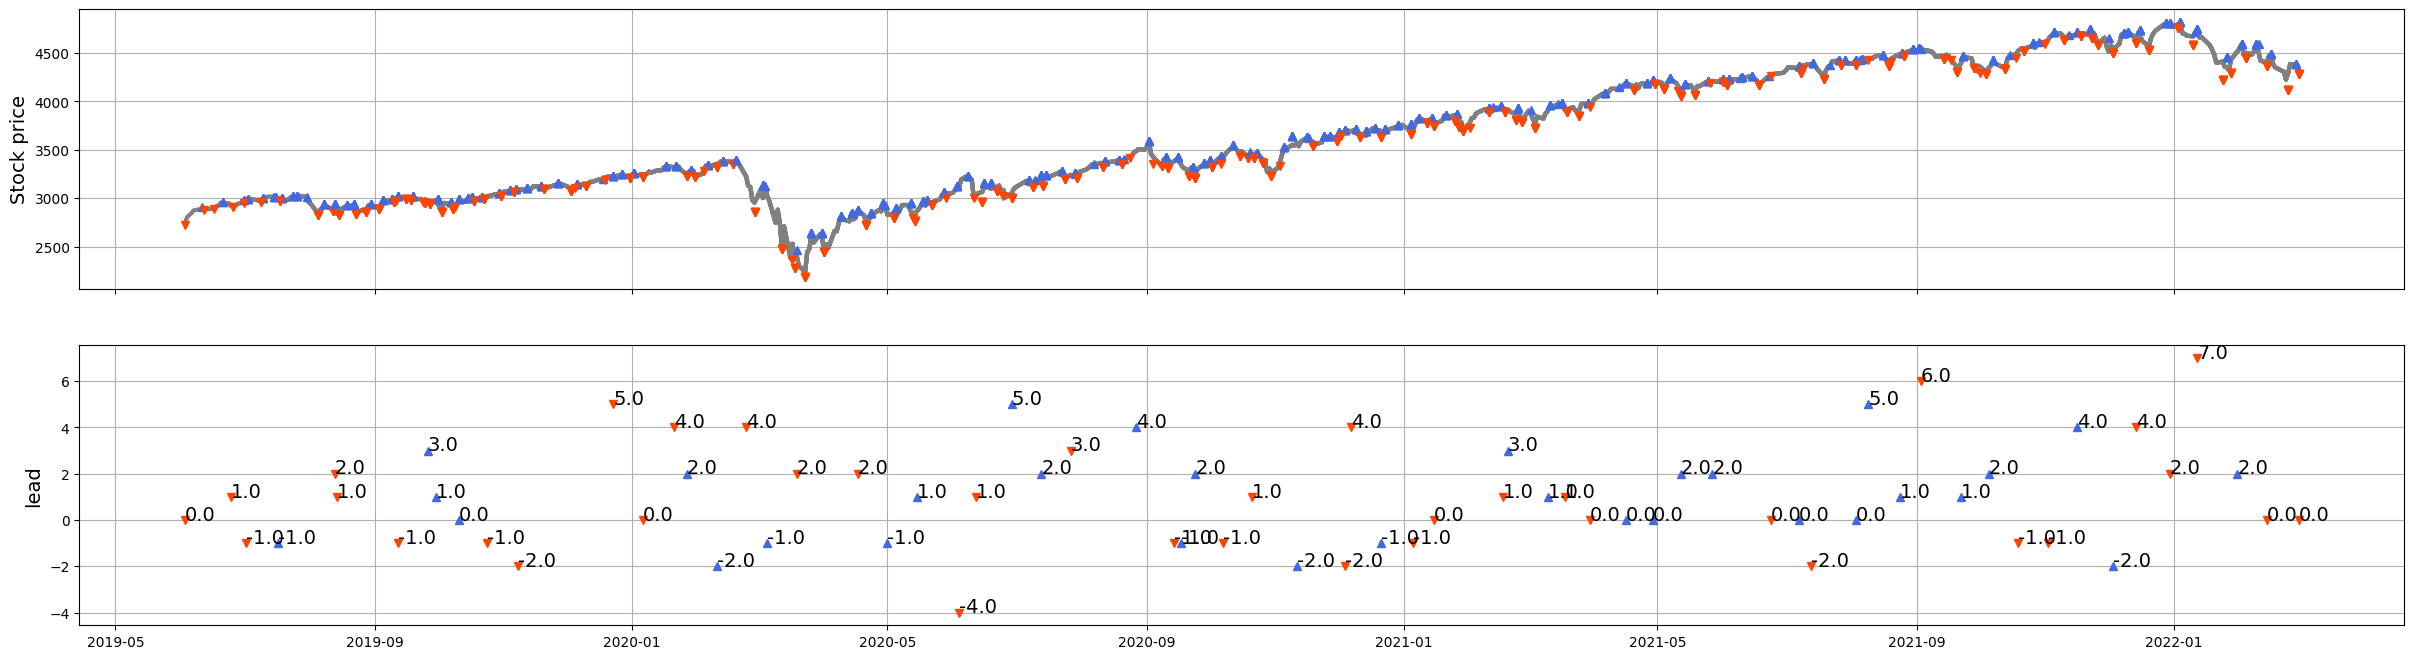

In [62]:
stock_name = "^GSPC"
date_predict_start = '2019-06-01'
data_range = 50
slide_range = 10
n_slide = 70
pv_range = 2
n_harm_lower_limit = 1
n_harm_upper_limit = 24
fit_method = 'mean'
pv_method = 'HL'
harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error = main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
    n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method)


final_error =  2.07
             s_date      t_date lead    ans_date      pv error best_fit
data_0   2019-06-03  2019-06-03  5.0  2019-06-10    peak   0.5       22
data_1   2019-06-17  2019-06-17  0.0  2019-06-17  valley  0.41       19
data_2   2019-07-01  2019-07-02 -1.0  2019-07-01  valley  0.39       23
data_3   2019-07-16  2019-07-16  0.0  2019-07-16    peak  0.27       23
data_4   2019-07-30  2019-07-31 -1.0  2019-07-30    peak  0.71       13
data_5   2019-08-13  2019-08-13  1.0  2019-08-14  valley  0.25       23
data_6   2019-08-27  2019-08-27  0.0  2019-08-27  valley   0.0       24
data_7   2019-09-11  2019-09-11  3.0  2019-09-16  valley   0.0       24
data_8   2019-09-25  2019-09-25  0.0  2019-09-25    peak  0.22       23
data_9   2019-10-09  2019-10-24 -4.0  2019-10-18  valley   0.0        1
data_10  2019-10-23  2019-10-25 -2.0  2019-10-23  valley  0.73       14
data_11  2019-11-06  2019-11-07 -1.0  2019-11-06  valley  1.08       18
data_12  2019-11-20  2019-11-22  3.0  2019-1

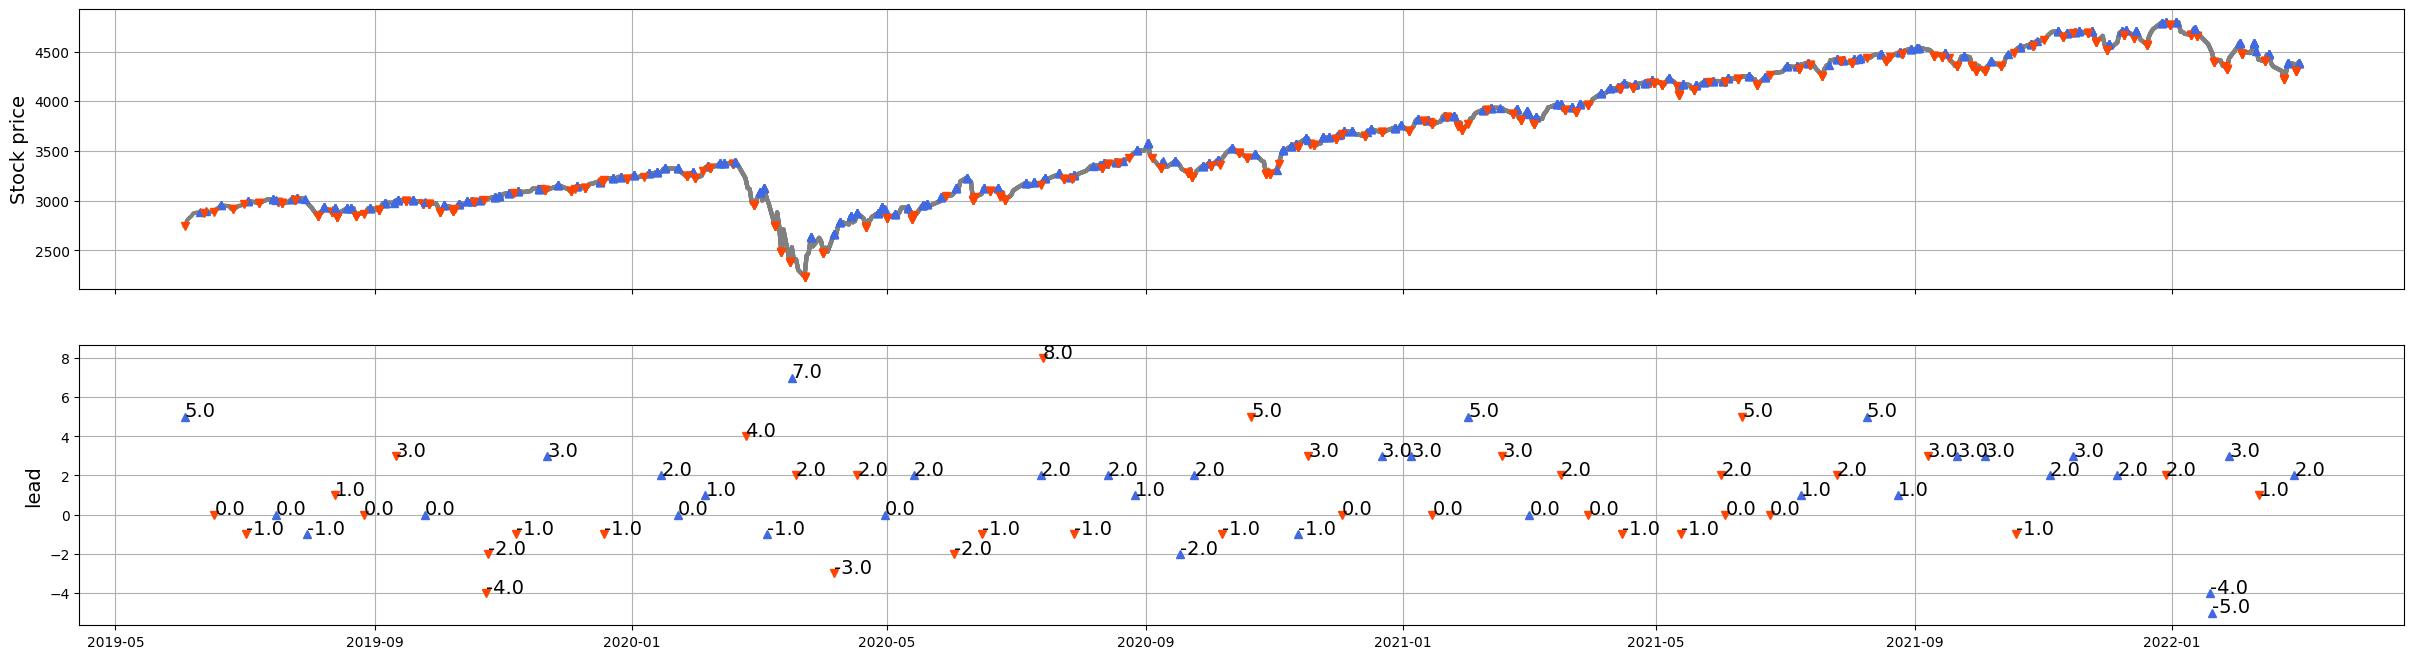

In [63]:
stock_name = "^GSPC"
date_predict_start = '2019-06-01'
data_range = 50
slide_range = 10
n_slide = 70
pv_range = 2
n_harm_lower_limit = 1
n_harm_upper_limit = 24
fit_method = 'rmse'
pv_method = 'CL'
harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error = main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
    n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method)


final_error =  2.17
             s_date      t_date lead    ans_date      pv error best_fit
data_0   2019-06-03  2019-06-04  5.0  2019-06-11    peak  0.77        9
data_1   2019-06-17  2019-07-05 -1.0  2019-07-03    peak  0.58        1
data_2   2019-07-01  2019-07-02 -1.0  2019-07-01  valley  0.79        7
data_3   2019-07-16  2019-07-16  0.0  2019-07-16    peak  0.71       24
data_4   2019-07-30  2019-08-09  1.0  2019-08-12  valley  0.82        1
data_5   2019-08-13  2019-08-13  2.0  2019-08-15  valley  0.58       12
data_6   2019-08-27  2019-09-30  1.0  2019-10-01    peak   0.0        1
data_7   2019-09-11  2019-09-11  0.0  2019-09-11  valley  0.56       24
data_8   2019-09-25  2019-09-26  3.0  2019-10-01    peak  0.68       13
data_9   2019-10-09  2019-10-09  2.0  2019-10-11    peak  0.62       24
data_10  2019-10-23  2019-10-23  5.0  2019-10-30    peak  0.56       23
data_11  2019-11-06  2019-11-07 -1.0  2019-11-06  valley  0.61       17
data_12  2019-11-20  2019-11-22  3.0  2019-1

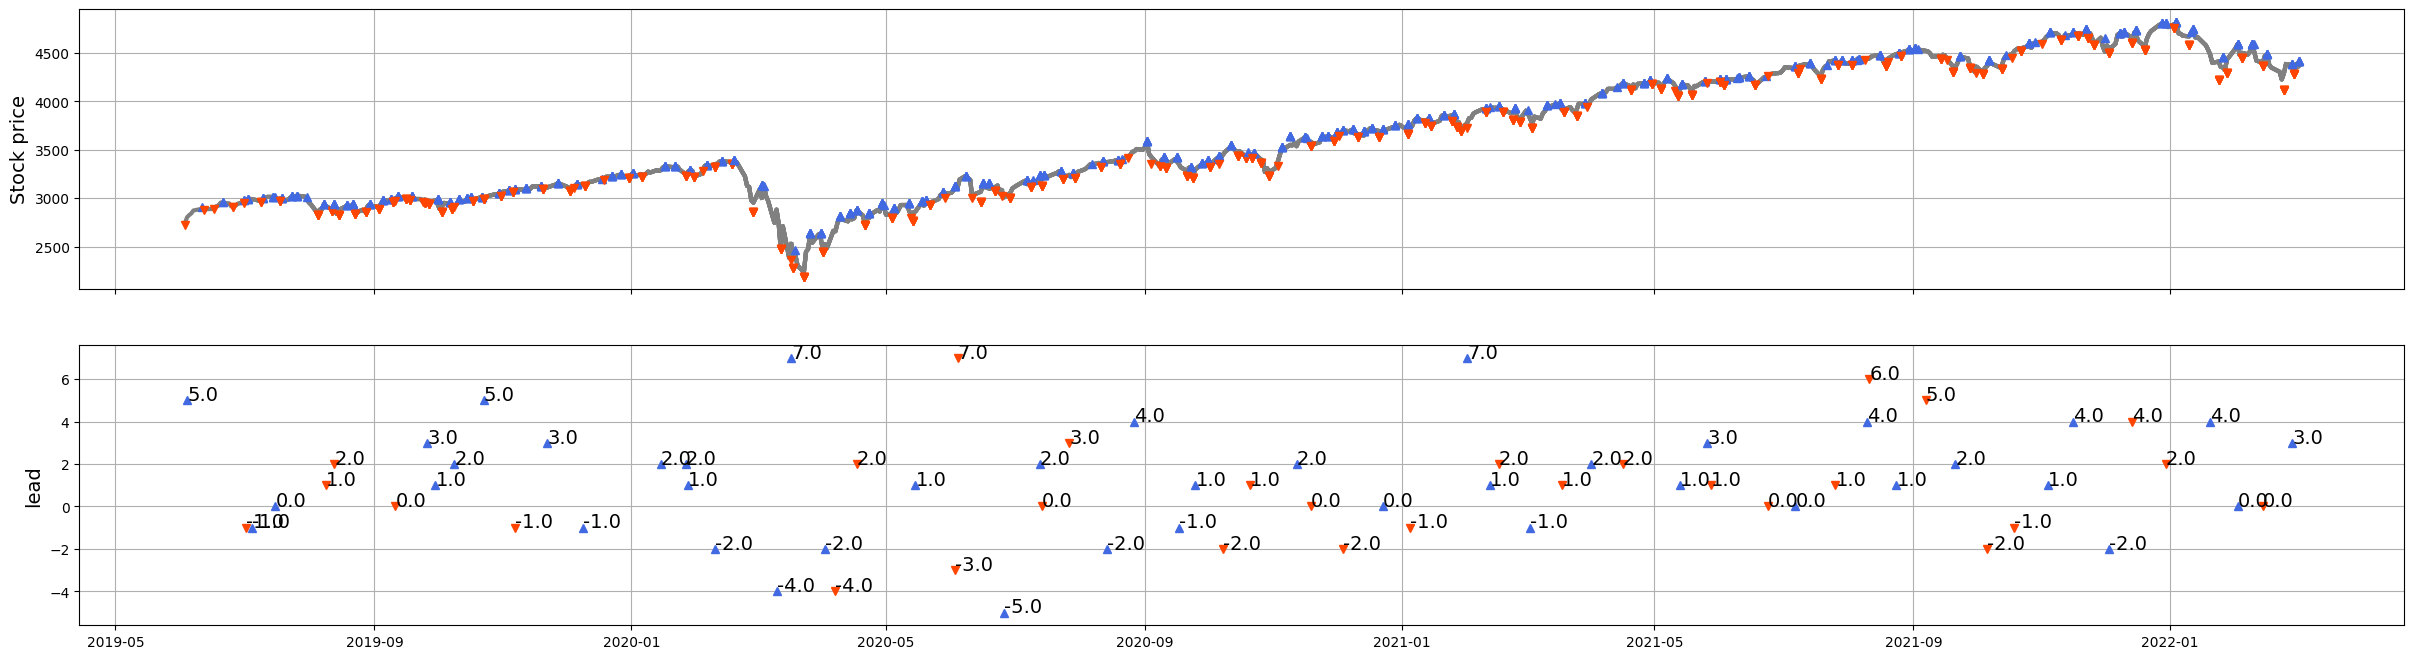

In [64]:
stock_name = "^GSPC"
date_predict_start = '2019-06-01'
data_range = 50
slide_range = 10
n_slide = 70
pv_range = 2
n_harm_lower_limit = 1
n_harm_upper_limit = 24
fit_method = 'rmse'
pv_method = 'HL'
harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error = main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
    n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method)


final_error =  1.53
             s_date      t_date lead    ans_date      pv error best_fit
data_0   2019-06-03  2019-06-05  3.0  2019-06-10    peak  0.38       48
data_1   2019-06-17  2019-06-17  0.0  2019-06-17  valley  0.23       49
data_2   2019-07-01  2019-07-02 -1.0  2019-07-01  valley  0.21       49
data_3   2019-07-16  2019-07-16  3.0  2019-07-19  valley  0.14       49
data_4   2019-07-30  2019-07-31  3.0  2019-08-05  valley  0.13       49
data_5   2019-08-13  2019-08-13  0.0  2019-08-13    peak  0.14       49
data_6   2019-08-27  2019-08-29  1.0  2019-08-30    peak  0.03       49
data_7   2019-09-11  2019-09-11  3.0  2019-09-16  valley  0.03       46
data_8   2019-09-25  2019-09-25  0.0  2019-09-25    peak  0.14       46
data_9   2019-10-09  2019-10-09  2.0  2019-10-11    peak  0.11       49
data_10  2019-10-23  2019-10-23  0.0  2019-10-23  valley  0.05       49
data_11  2019-11-06  2019-11-06  0.0  2019-11-06  valley  0.18       45
data_12  2019-11-20  2019-11-20  1.0  2019-1

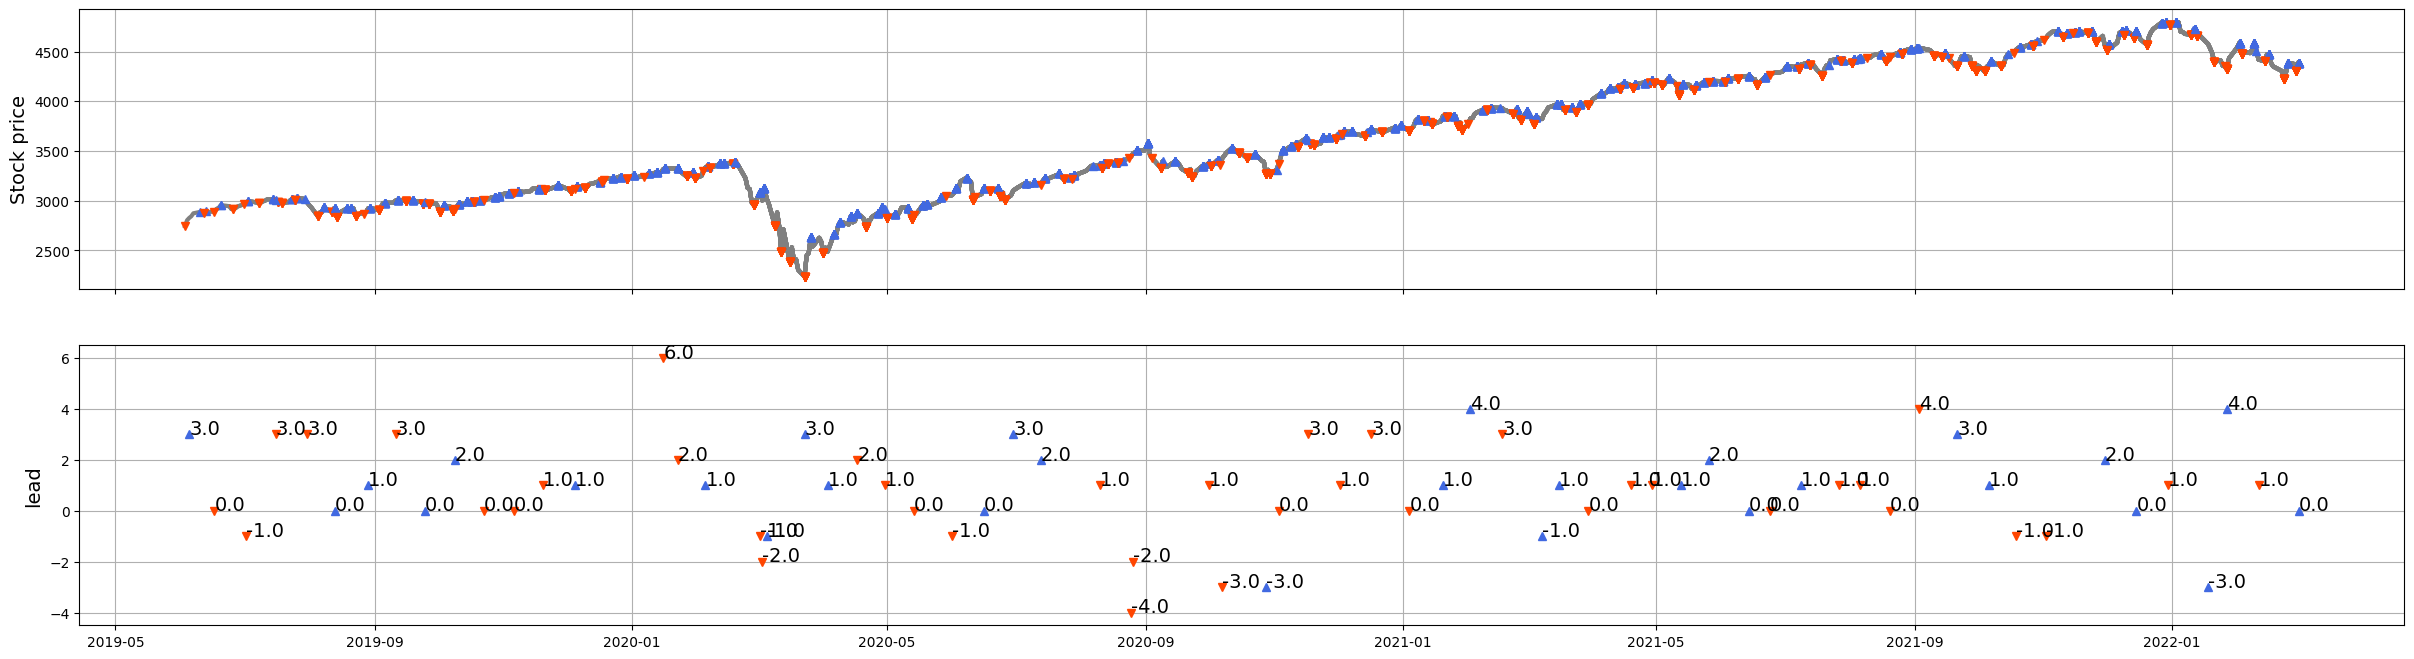

In [65]:
stock_name = "^GSPC"
date_predict_start = '2019-06-01'
data_range = 100
slide_range = 10
n_slide = 70
pv_range = 2
n_harm_lower_limit = 1
n_harm_upper_limit = 49
fit_method = 'abs'
pv_method = 'CL'
harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error = main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
    n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method)


final_error =  1.56
             s_date      t_date lead    ans_date      pv error best_fit
data_0   2019-06-03  2019-07-15  0.0  2019-07-15    peak  0.57        6
data_1   2019-06-17  2019-06-18 -1.0  2019-06-17  valley  0.66       40
data_2   2019-07-01  2019-07-02 -1.0  2019-07-01  valley  0.63       38
data_3   2019-07-16  2019-07-16  2.0  2019-07-18  valley  0.62       44
data_4   2019-07-30  2019-07-31  3.0  2019-08-05  valley  0.62       24
data_5   2019-08-13  2019-08-15  0.0  2019-08-15  valley  0.57       17
data_6   2019-08-27  2019-09-17  2.0  2019-09-19    peak   0.2        4
data_7   2019-09-11  2019-09-19  0.0  2019-09-19    peak  0.44       29
data_8   2019-09-25  2019-10-18  0.0  2019-10-18  valley   0.4        3
data_9   2019-10-09  2019-10-09  2.0  2019-10-11    peak  0.53       46
data_10  2019-10-23  2019-10-23  0.0  2019-10-23  valley  0.47       46
data_11  2019-11-06  2019-11-06  0.0  2019-11-06  valley  0.46       48
data_12  2019-11-20  2019-11-20  0.0  2019-1

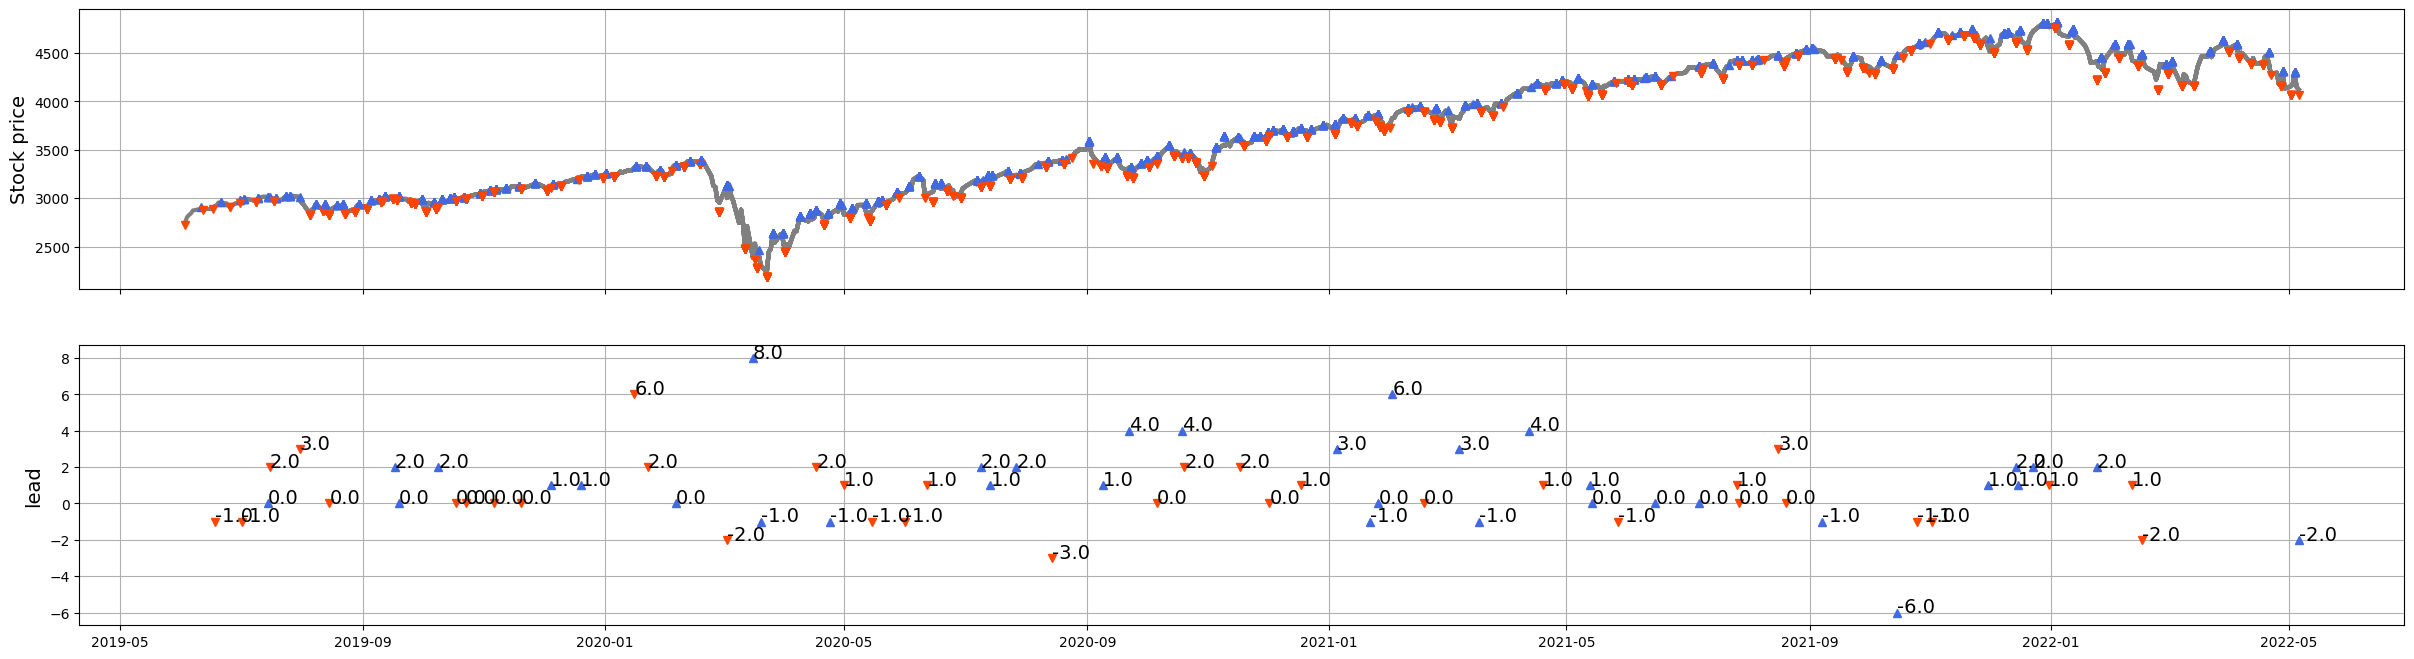

In [66]:
stock_name = "^GSPC"
date_predict_start = '2019-06-01'
data_range = 100
slide_range = 10
n_slide = 70
pv_range = 2
n_harm_lower_limit = 1
n_harm_upper_limit = 49
fit_method = 'abs'
pv_method = 'HL'
harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error = main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
    n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method)


final_error =  1.4
             s_date      t_date lead    ans_date      pv error best_fit
data_0   2019-06-03  2019-06-14 -3.0  2019-06-11    peak   0.0        7
data_1   2019-06-17  2019-06-18 -1.0  2019-06-17  valley   0.0        1
data_2   2019-07-01  2019-07-03 -2.0  2019-07-01  valley   0.0        9
data_3   2019-07-16  2019-07-22 -2.0  2019-07-18  valley   0.0       12
data_4   2019-07-30  2019-08-05  0.0  2019-08-05  valley   0.0        5
data_5   2019-08-13  2019-08-27  3.0  2019-08-30    peak   0.0        6
data_6   2019-08-27  2019-09-17  2.0  2019-09-19    peak   0.0        6
data_7   2019-09-11  2019-09-18  1.0  2019-09-19    peak   0.0        4
data_8   2019-09-25  2019-09-25  4.0  2019-10-01    peak   0.0       40
data_9   2019-10-09  2019-10-09  2.0  2019-10-11    peak  0.03       46
data_10  2019-10-23  2019-10-24 -1.0  2019-10-23  valley   0.0       25
data_11  2019-11-06  2019-11-11 -3.0  2019-11-06  valley   0.0       13
data_12  2019-11-20  2019-11-22 -2.0  2019-11

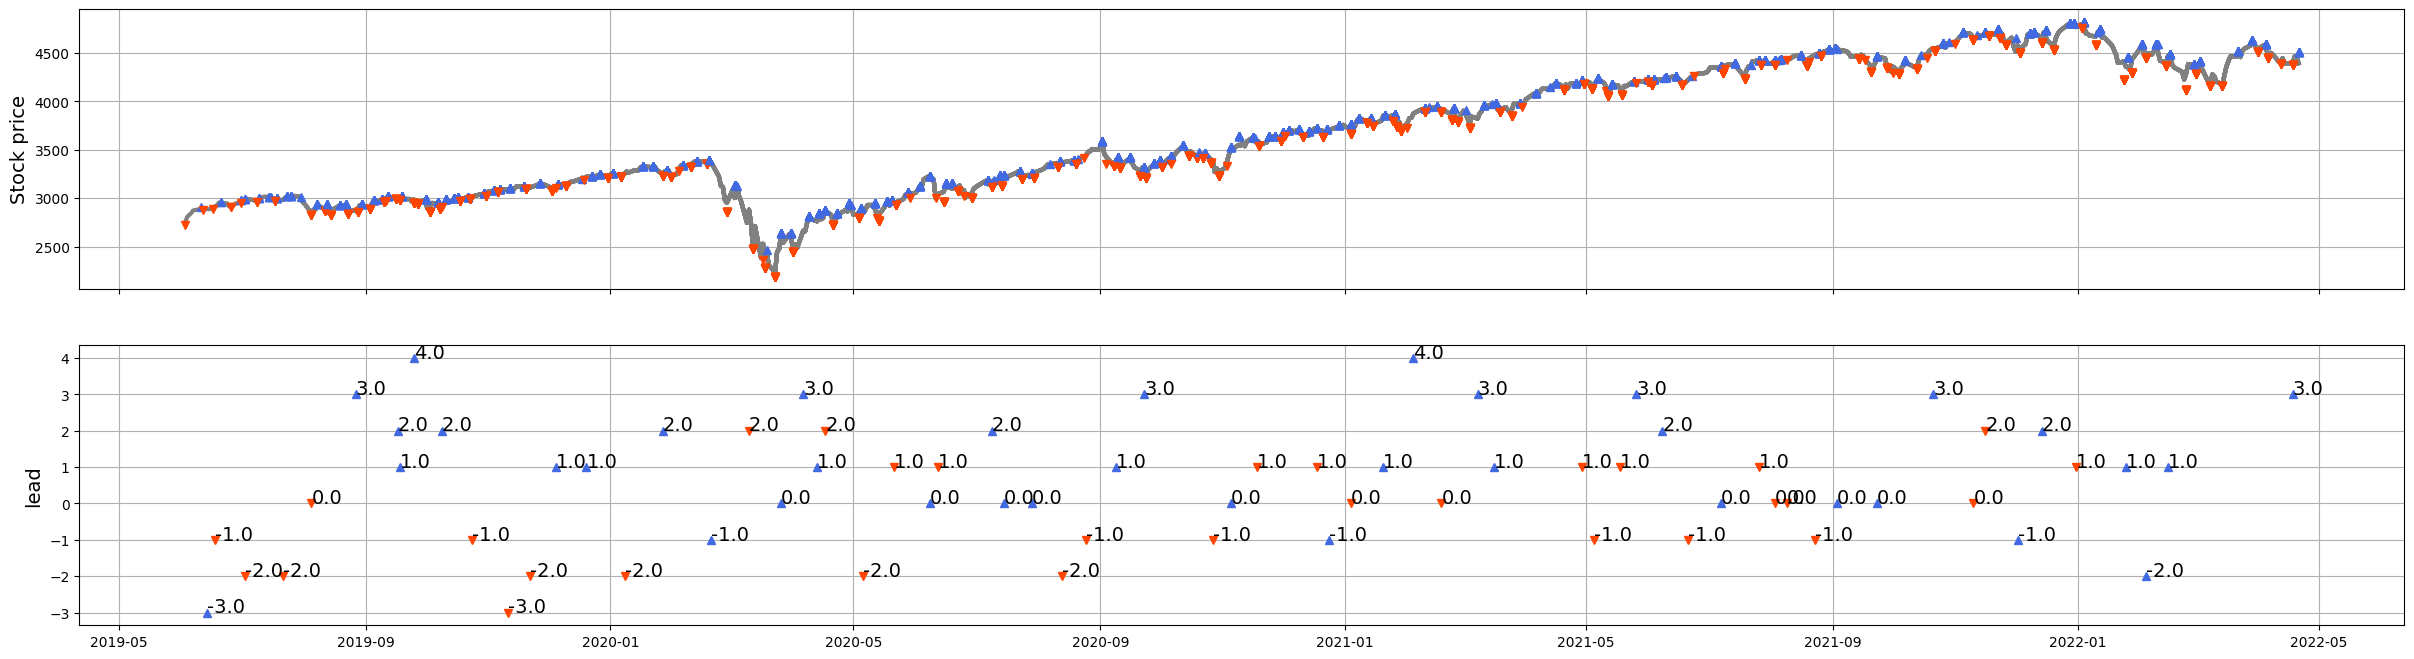

In [69]:
stock_name = "^GSPC"
date_predict_start = '2019-06-01'
data_range = 100
slide_range = 10
n_slide = 70
pv_range = 2
n_harm_lower_limit = 1
n_harm_upper_limit = 49
fit_method = 'mean'
pv_method = 'HL'
harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error = main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
    n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method)


final_error =  1.44
             s_date      t_date lead    ans_date      pv error best_fit
data_0   2019-06-03  2019-07-15  0.0  2019-07-15    peak  0.76        6
data_1   2019-06-17  2019-06-18 -1.0  2019-06-17  valley  0.79       40
data_2   2019-07-01  2019-07-02 -1.0  2019-07-01  valley  0.75       43
data_3   2019-07-16  2019-07-16  3.0  2019-07-19  valley   0.6       45
data_4   2019-07-30  2019-07-31  3.0  2019-08-05  valley  0.37       44
data_5   2019-08-13  2019-08-13  0.0  2019-08-13    peak  0.68       49
data_6   2019-08-27  2019-08-29  1.0  2019-08-30    peak  0.16       49
data_7   2019-09-11  2019-09-11  3.0  2019-09-16  valley  0.17       46
data_8   2019-09-25  2019-09-25  0.0  2019-09-25    peak  0.69       44
data_9   2019-10-09  2019-10-09  2.0  2019-10-11    peak  0.53       49
data_10  2019-10-23  2019-10-23  0.0  2019-10-23  valley  0.23       49
data_11  2019-11-06  2019-11-06  0.0  2019-11-06  valley  0.42       45
data_12  2019-11-20  2019-11-22  3.0  2019-1

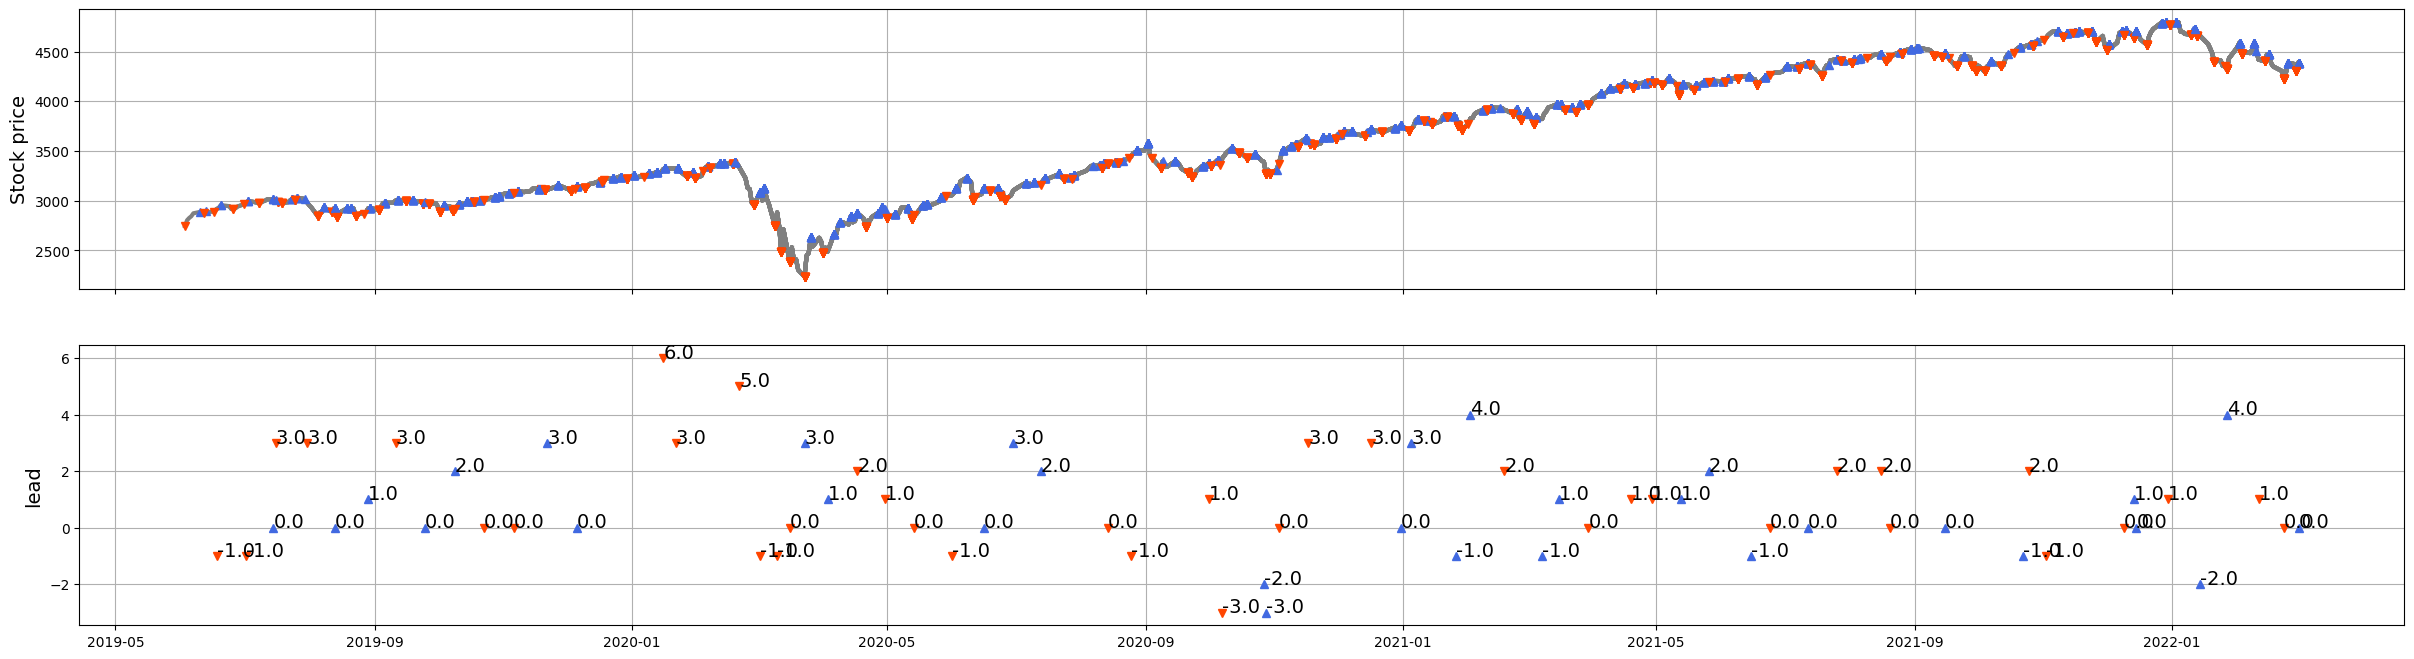

In [99]:
stock_name = "^GSPC"
date_predict_start = '2019-06-01'
data_range = 100
slide_range = 10
n_slide = 70
pv_range = 2
n_harm_lower_limit = 1
n_harm_upper_limit = 49
fit_method = 'rmse'
pv_method = 'CL'
harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error = main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
    n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method)


final_error =  1.59
             s_date      t_date lead    ans_date      pv error best_fit
data_0   2019-06-03  2019-07-15  0.0  2019-07-15    peak  0.76        6
data_1   2019-06-17  2019-06-19 -2.0  2019-06-17  valley  0.92       17
data_2   2019-07-01  2019-07-02 -1.0  2019-07-01  valley  1.07       38
data_3   2019-07-16  2019-07-19 -1.0  2019-07-18  valley   0.9       15
data_4   2019-07-30  2019-07-31  3.0  2019-08-05  valley  0.81       17
data_5   2019-08-13  2019-08-13  0.0  2019-08-13    peak  0.77       15
data_6   2019-08-27  2019-09-17  2.0  2019-09-19    peak  0.45        4
data_7   2019-09-11  2019-09-11  0.0  2019-09-11  valley  0.71       18
data_8   2019-09-25  2019-09-26  3.0  2019-10-01    peak  0.72       28
data_9   2019-10-09  2019-10-11  0.0  2019-10-11    peak  0.88       25
data_10  2019-10-23  2019-10-24 -1.0  2019-10-23  valley  0.79       29
data_11  2019-11-06  2019-11-07 -1.0  2019-11-06  valley  0.77       32
data_12  2019-11-20  2019-11-20  0.0  2019-1

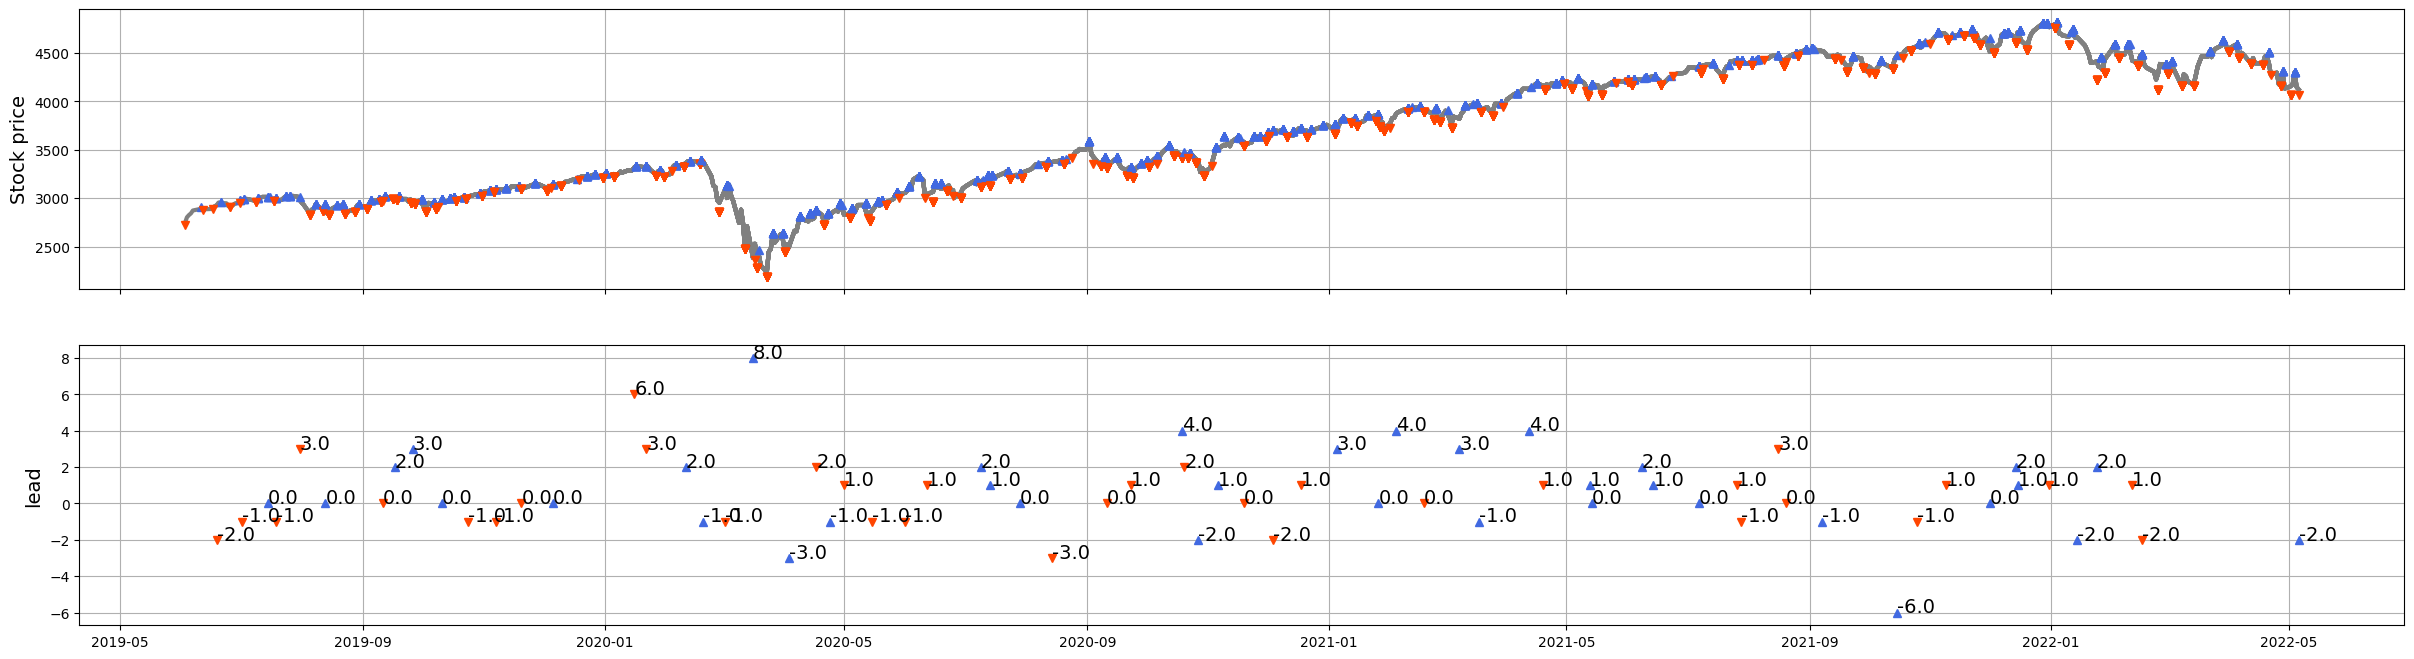

In [100]:
stock_name = "^GSPC"
date_predict_start = '2019-06-01'
data_range = 100
slide_range = 10
n_slide = 70
pv_range = 2
n_harm_lower_limit = 1
n_harm_upper_limit = 49
fit_method = 'rmse'
pv_method = 'HL'
harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error = main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
    n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method)


final_error =  1.29
             s_date      t_date lead    ans_date      pv error best_fit
data_0   2019-06-03  2019-07-03  0.0  2019-07-03    peak  0.43        4
data_1   2019-06-17  2019-06-18  2.0  2019-06-20    peak  0.62       63
data_2   2019-07-01  2019-07-02  1.0  2019-07-03    peak  0.56       63
data_3   2019-07-16  2019-07-17 -1.0  2019-07-16    peak  0.67       67
data_4   2019-07-30  2019-07-31 -1.0  2019-07-30    peak  0.43       66
data_5   2019-08-13  2019-08-14 -1.0  2019-08-13    peak  0.44       66
data_6   2019-08-27  2019-10-03 -1.0  2019-10-02  valley  0.33        1
data_7   2019-09-11  2019-09-20 -1.0  2019-09-19    peak  0.42       66
data_8   2019-09-25  2020-02-07 -1.0  2020-02-06    peak  0.33        1
data_9   2019-10-09  2019-10-10 -1.0  2019-10-09  valley  0.51       67
data_10  2019-10-23  2020-01-22  1.0  2020-01-23    peak   0.4        2
data_11  2019-11-06  2019-11-07 -1.0  2019-11-06  valley  0.45       69
data_12  2019-11-20  2019-11-21  0.0  2019-1

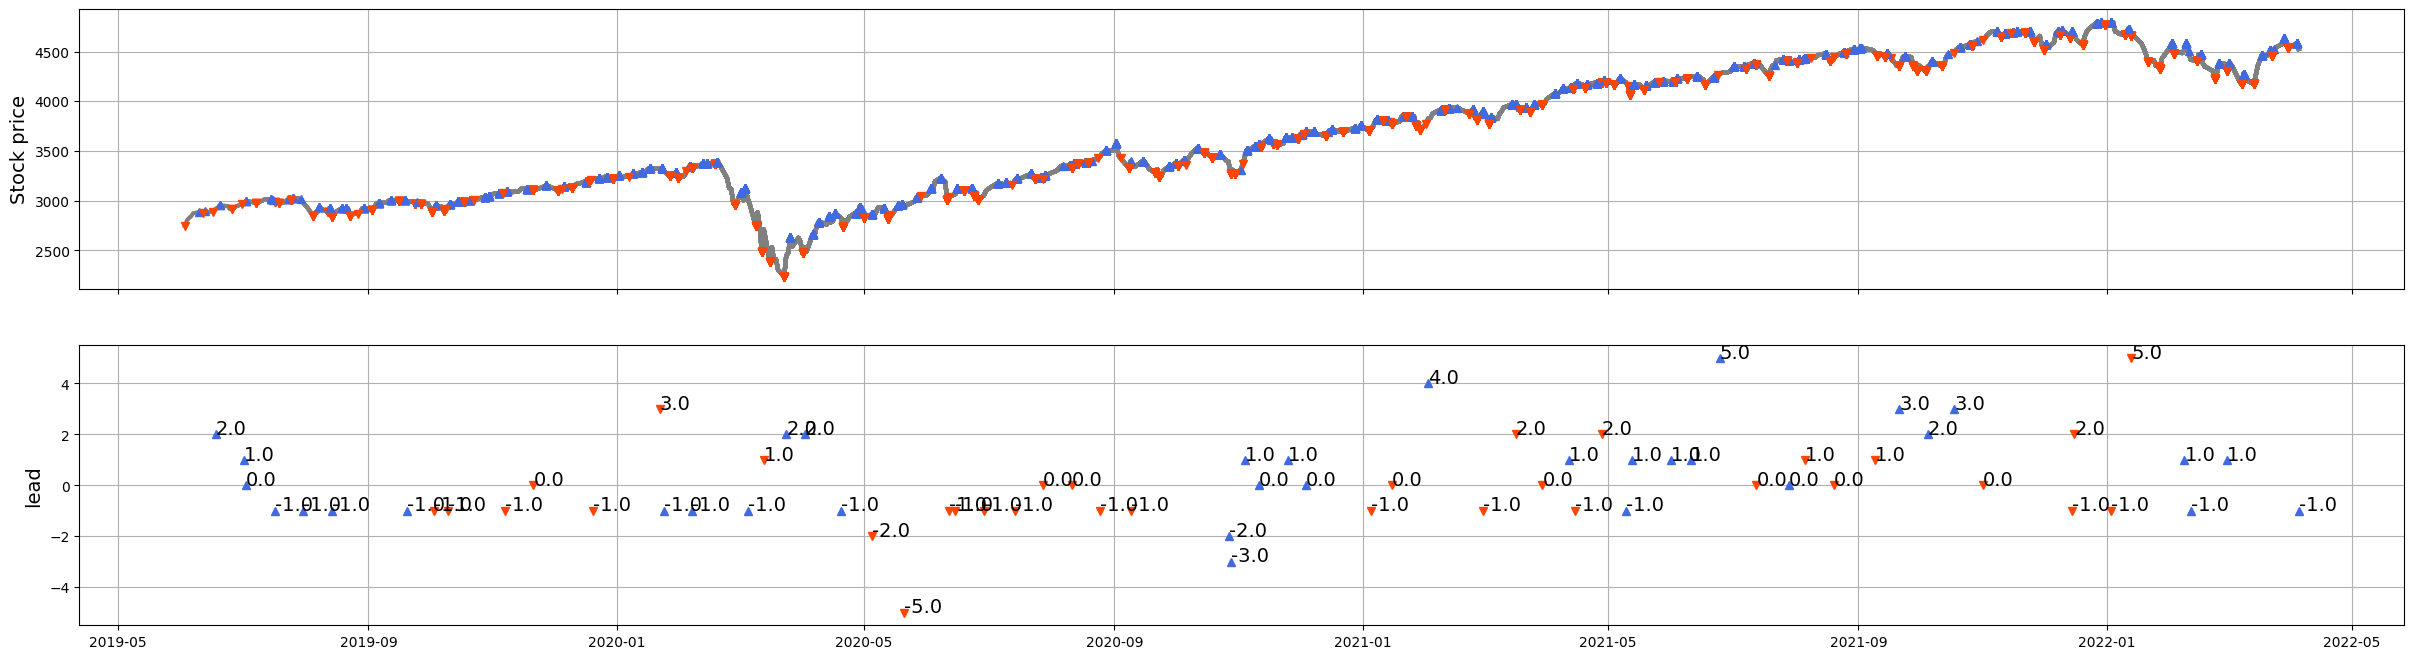

In [101]:
stock_name = "^GSPC"
date_predict_start = '2019-06-01'
data_range = 200
slide_range = 10
n_slide = 70
pv_range = 2
n_harm_lower_limit = 1
n_harm_upper_limit = 70
fit_method = 'abs'
pv_method = 'CL'
harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error = main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
    n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method)


final_error =  1.87
             s_date      t_date lead    ans_date      pv error best_fit
data_0   2019-06-03  2019-06-18  3.0  2019-06-21    peak  0.46       11
data_1   2019-06-17  2019-06-18  3.0  2019-06-21    peak  0.79       69
data_2   2019-07-01  2019-07-17  2.0  2019-07-19    peak  0.45       10
data_3   2019-07-16  2019-07-23  1.0  2019-07-24    peak  0.62       11
data_4   2019-07-30  2019-11-11 -3.0  2019-11-06  valley  0.33        1
data_5   2019-08-13  2019-08-27  3.0  2019-08-30    peak  0.74       27
data_6   2019-08-27  2019-08-28  2.0  2019-08-30    peak  0.71       55
data_7   2019-09-11  2019-09-19  0.0  2019-09-19    peak  0.63       55
data_8   2019-09-25  2020-02-07 -1.0  2020-02-06    peak  0.33        1
data_9   2019-10-09  2019-10-10 -1.0  2019-10-09  valley  0.65       54
data_10  2019-10-23  2020-01-22  0.0  2020-01-22    peak   0.4        2
data_11  2019-11-06  2019-11-07 -1.0  2019-11-06  valley   0.6       68
data_12  2019-11-20  2019-11-21 -1.0  2019-1

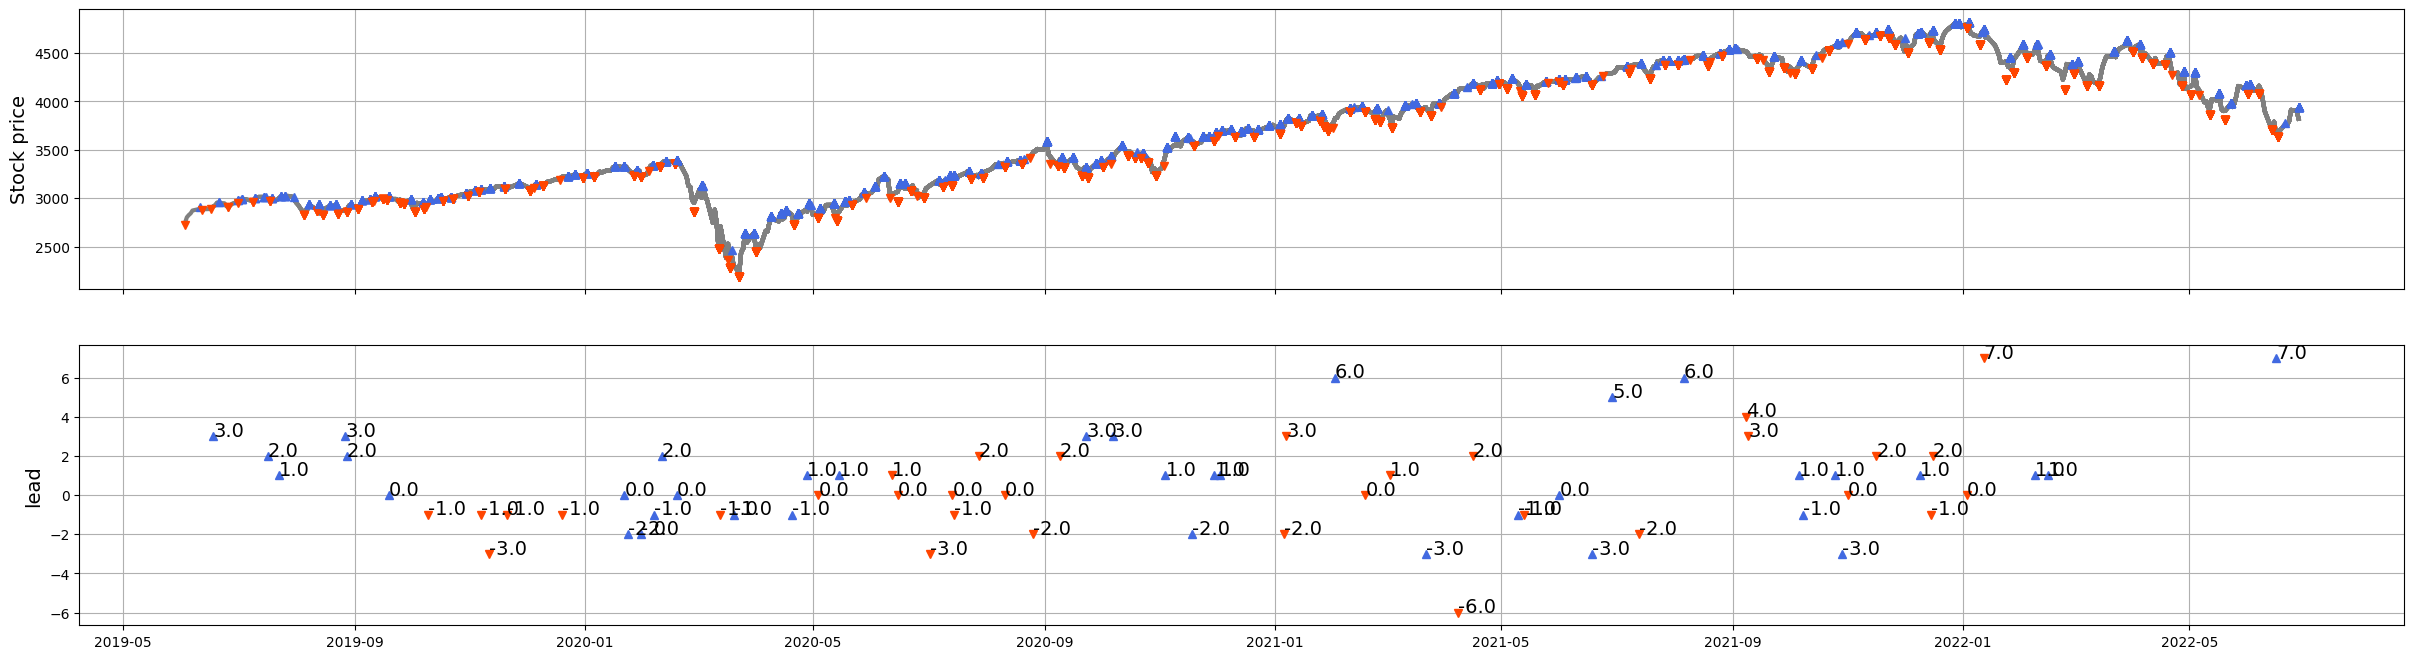

In [102]:
stock_name = "^GSPC"
date_predict_start = '2019-06-01'
data_range = 200
slide_range = 10
n_slide = 70
pv_range = 2
n_harm_lower_limit = 1
n_harm_upper_limit = 70
fit_method = 'abs'
pv_method = 'HL'
harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error = main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
    n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method)


final_error =  1.73
             s_date      t_date lead    ans_date      pv error best_fit
data_0   2019-06-03  2019-06-19  1.0  2019-06-20    peak   0.0       22
data_1   2019-06-17  2019-06-20  0.0  2019-06-20    peak   0.0       22
data_2   2019-07-01  2019-07-19  3.0  2019-07-24    peak   0.0        2
data_3   2019-07-16  2019-07-22  2.0  2019-07-24    peak   0.0       25
data_4   2019-07-30  2019-08-07  1.0  2019-08-08    peak   0.0        2
data_5   2019-08-13  2019-08-26 -3.0  2019-08-21    peak   0.0       23
data_6   2019-08-27  2019-08-29  1.0  2019-08-30    peak   0.0       28
data_7   2019-09-11  2019-09-18  1.0  2019-09-19    peak   0.0        6
data_8   2019-09-25  2019-10-04  2.0  2019-10-08  valley   0.0        2
data_9   2019-10-09  2020-02-19  0.0  2020-02-19    peak   0.0        1
data_10  2019-10-23  2019-10-28 -3.0  2019-10-23  valley   0.0       19
data_11  2019-11-06  2019-11-15  4.0  2019-11-21  valley   0.0        8
data_12  2019-11-20  2020-02-19  0.0  2020-0

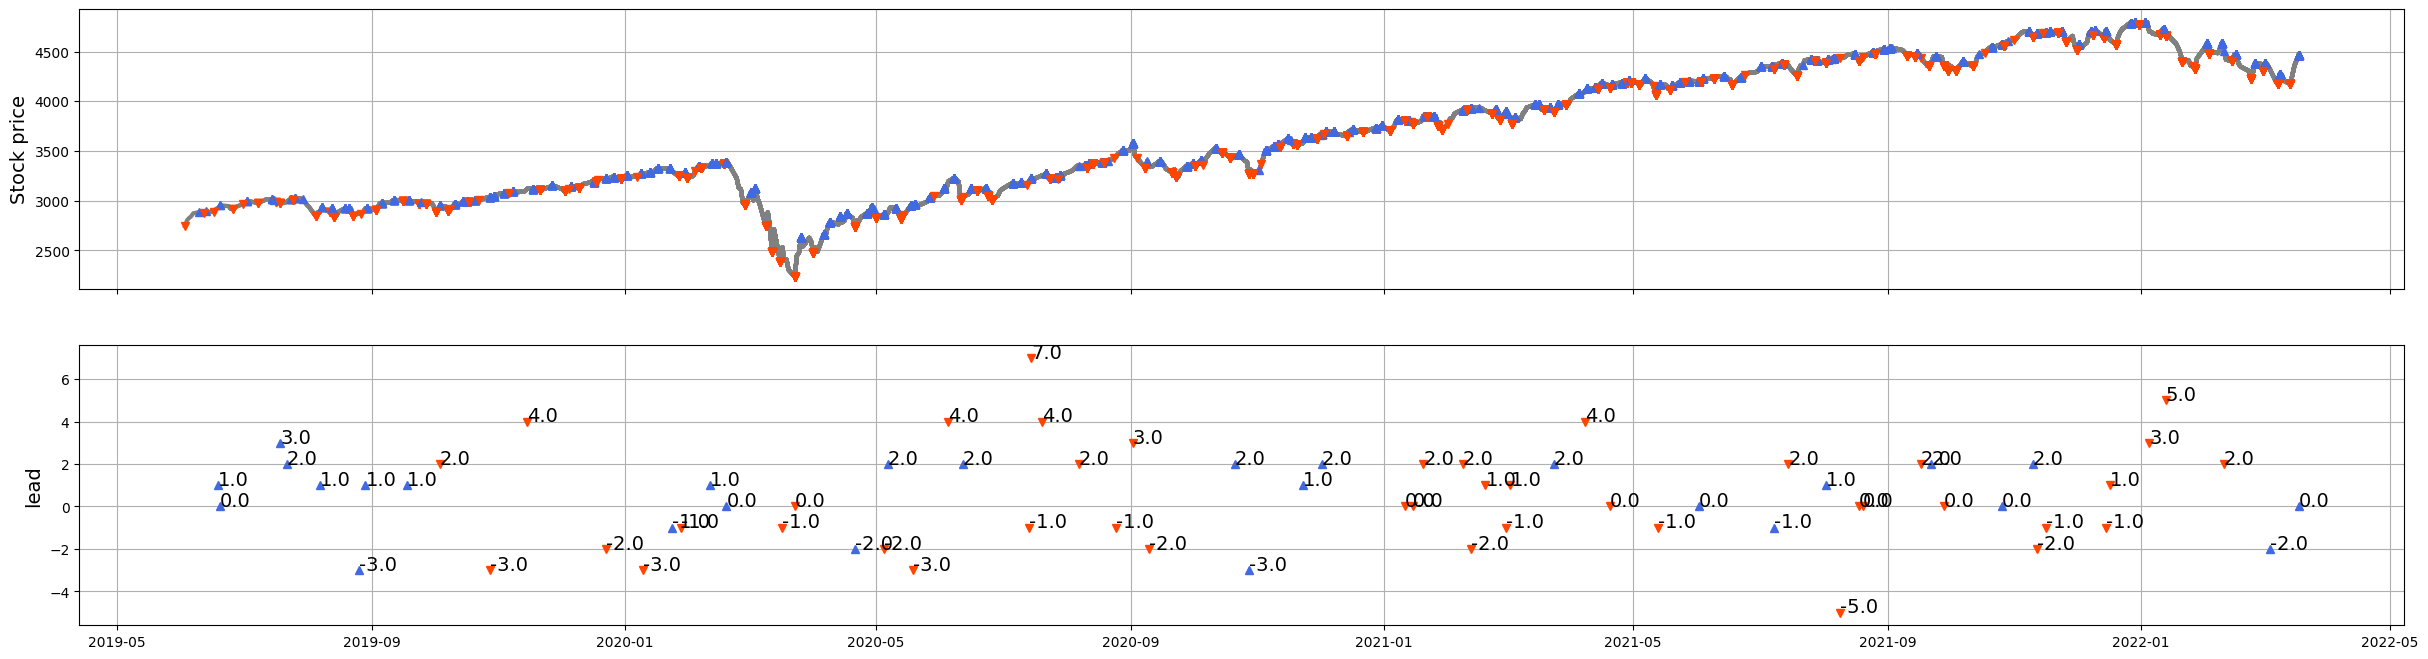

In [103]:
stock_name = "^GSPC"
date_predict_start = '2019-06-01'
data_range = 200
slide_range = 10
n_slide = 70
pv_range = 2
n_harm_lower_limit = 1
n_harm_upper_limit = 70
fit_method = 'mean'
pv_method = 'CL'
harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error = main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
    n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method)


final_error =  1.77
             s_date      t_date lead    ans_date      pv error best_fit
data_0   2019-06-03  2019-06-19  2.0  2019-06-21    peak   0.0       26
data_1   2019-06-17  2019-06-19  2.0  2019-06-21    peak   0.0       36
data_2   2019-07-01  2019-07-09  1.0  2019-07-10    peak   0.0       20
data_3   2019-07-16  2019-07-23  1.0  2019-07-24    peak   0.0       11
data_4   2019-07-30  2019-08-07  1.0  2019-08-08    peak   0.0        2
data_5   2019-08-13  2019-09-05  0.0  2019-09-05    peak   0.0        6
data_6   2019-08-27  2019-08-30  0.0  2019-08-30    peak   0.0       18
data_7   2019-09-11  2019-09-19  0.0  2019-09-19    peak   0.0       10
data_8   2019-09-25  2019-10-04 -1.0  2019-10-03  valley   0.0        2
data_9   2019-10-09  2020-02-19  0.0  2020-02-19    peak   0.0        1
data_10  2019-10-23  2019-10-28  3.0  2019-10-31  valley   0.0       22
data_11  2019-11-06  2020-03-09 -4.0  2020-03-03    peak   0.0        1
data_12  2019-11-20  2020-02-19  0.0  2020-0

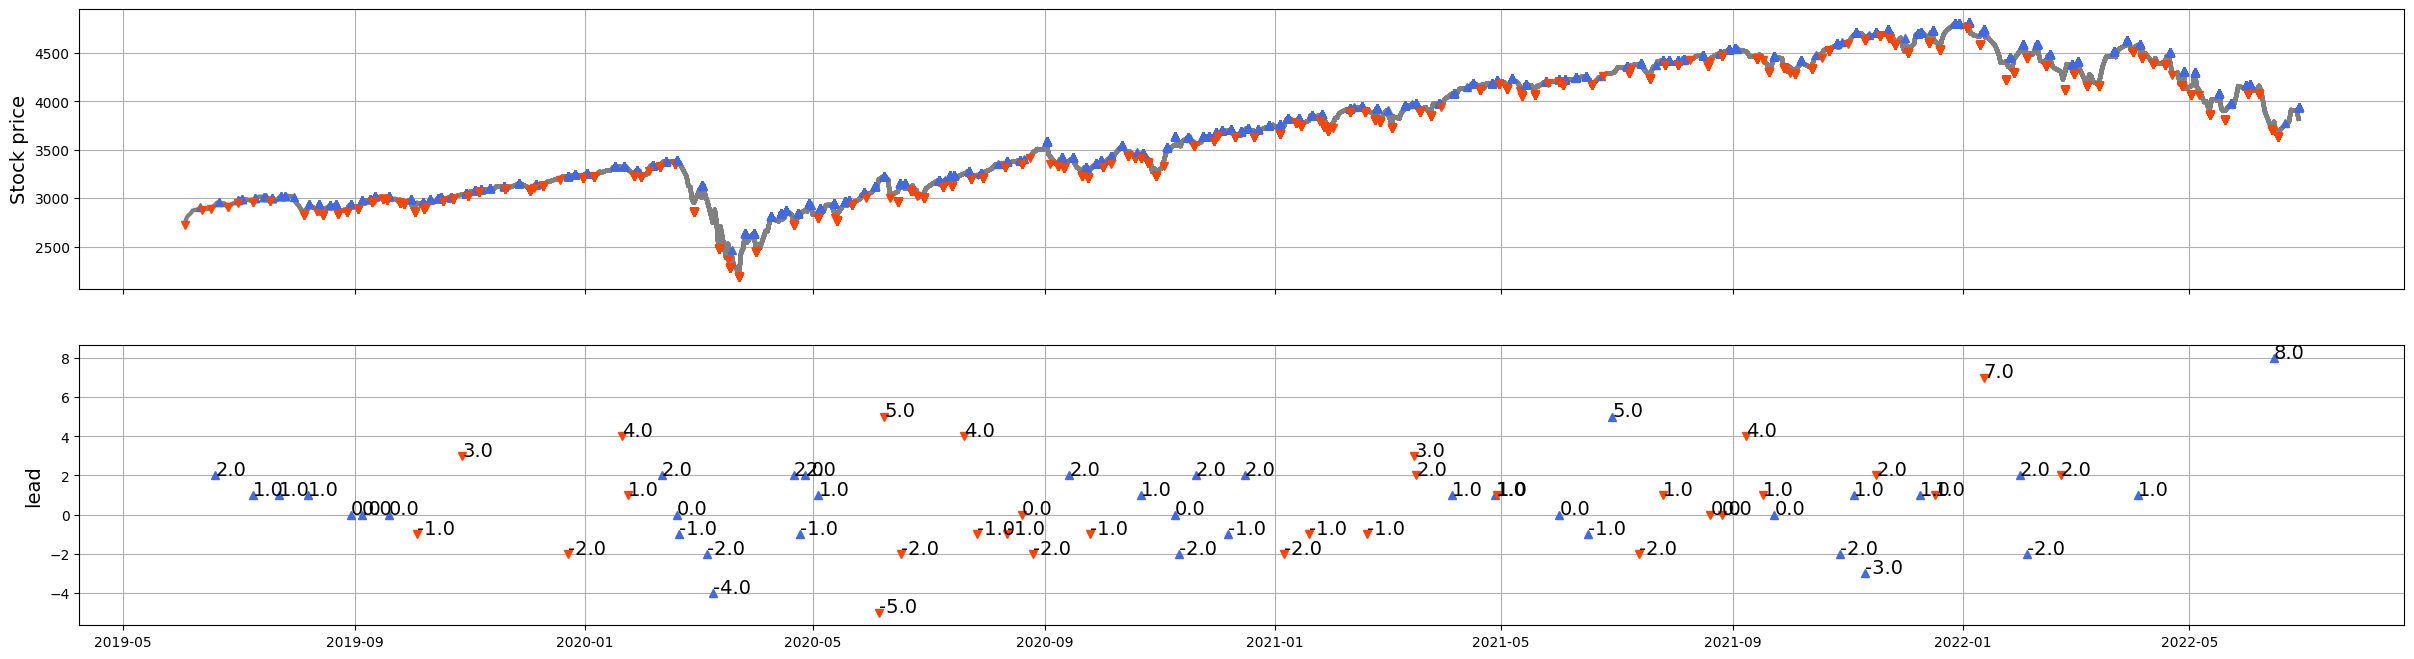

In [104]:
stock_name = "^GSPC"
date_predict_start = '2019-06-01'
data_range = 200
slide_range = 10
n_slide = 70
pv_range = 2
n_harm_lower_limit = 1
n_harm_upper_limit = 70
fit_method = 'mean'
pv_method = 'HL'
harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error = main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
    n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method)


final_error =  1.36
             s_date      t_date lead    ans_date      pv error best_fit
data_0   2019-06-03  2019-07-03  0.0  2019-07-03    peak  0.65        4
data_1   2019-06-17  2019-06-19  1.0  2019-06-20    peak  1.26       47
data_2   2019-07-01  2019-07-02  1.0  2019-07-03    peak  0.95       46
data_3   2019-07-16  2019-07-19  3.0  2019-07-24    peak  0.95       33
data_4   2019-07-30  2019-07-31 -1.0  2019-07-30    peak  0.72       66
data_5   2019-08-13  2019-08-14 -1.0  2019-08-13    peak  0.86       63
data_6   2019-08-27  2019-10-03 -1.0  2019-10-02  valley  0.58        1
data_7   2019-09-11  2019-09-19  0.0  2019-09-19    peak  0.73       49
data_8   2019-09-25  2020-02-07 -1.0  2020-02-06    peak  0.58        1
data_9   2019-10-09  2020-02-19  0.0  2020-02-19    peak  0.82        1
data_10  2019-10-23  2020-01-22  1.0  2020-01-23    peak  0.63        2
data_11  2019-11-06  2019-11-07 -1.0  2019-11-06  valley  0.91       69
data_12  2019-11-20  2020-02-19  0.0  2020-0

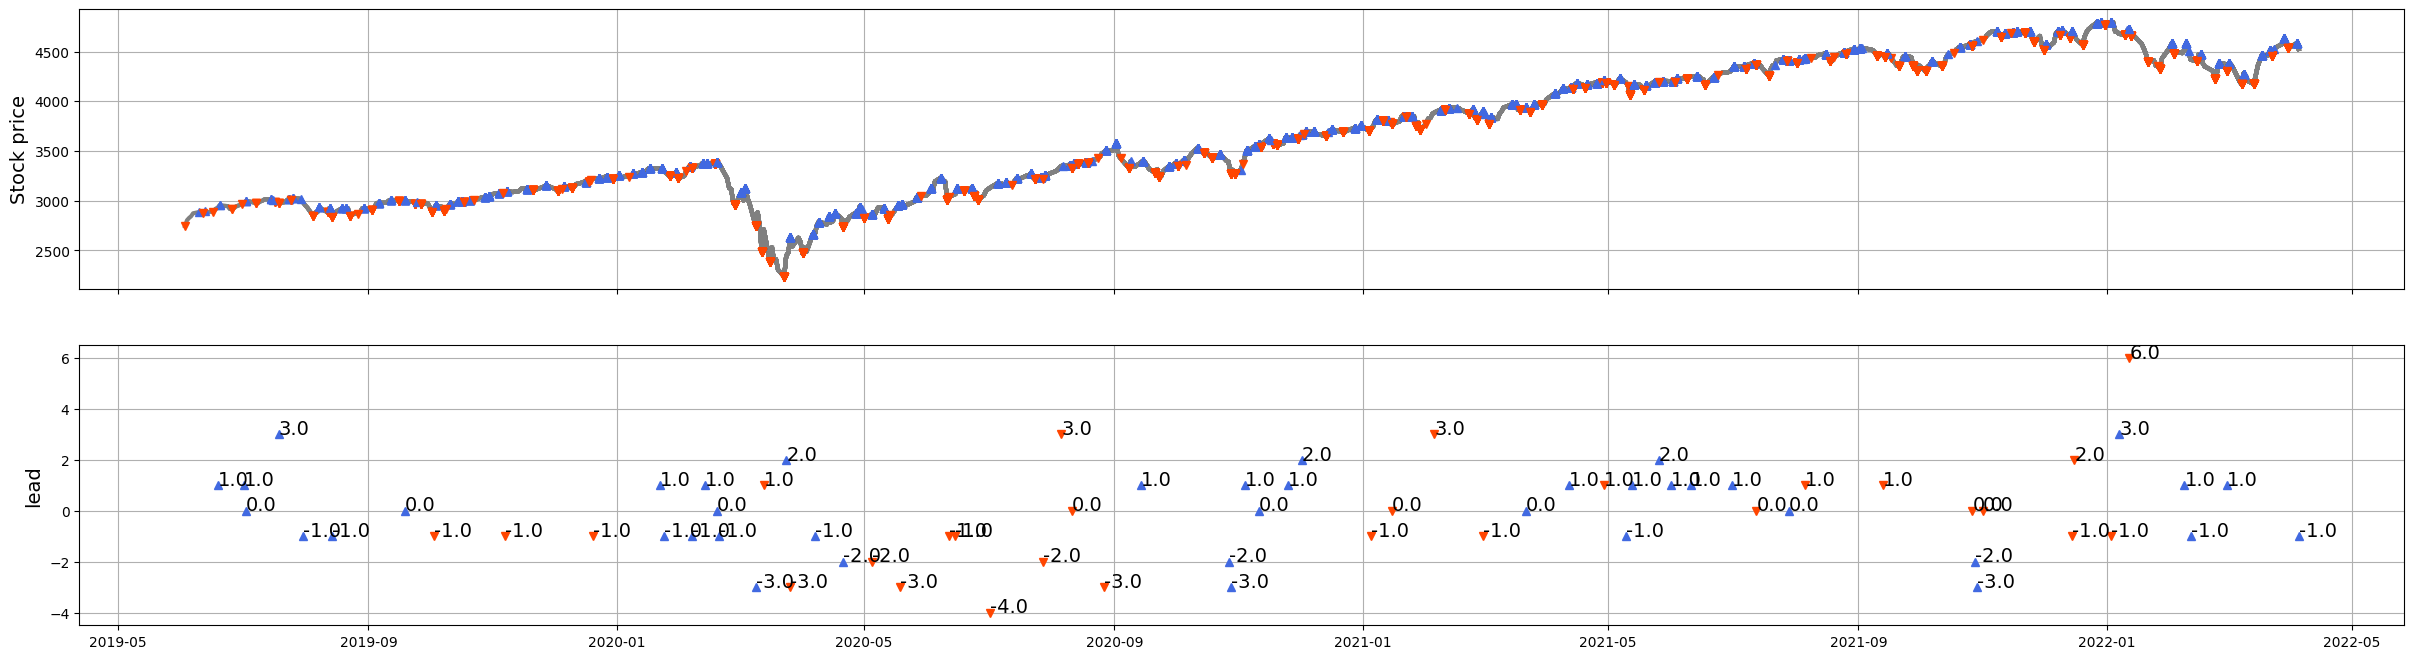

In [27]:
stock_name = "^GSPC"
date_predict_start = '2019-06-01'
data_range = 200
slide_range = 10
n_slide = 70
pv_range = 2
n_harm_lower_limit = 1
n_harm_upper_limit = 70
fit_method = 'rmse'
pv_method = 'CL'
harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error = main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
    n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method)


final_error =  1.7
             s_date      t_date lead    ans_date      pv error best_fit
data_0   2019-06-03  2019-06-18  3.0  2019-06-21    peak  0.68       11
data_1   2019-06-17  2019-06-20  1.0  2019-06-21    peak  1.54       27
data_2   2019-07-01  2019-07-17  2.0  2019-07-19    peak  0.67       10
data_3   2019-07-16  2019-07-22 -1.0  2019-07-19    peak  0.91       18
data_4   2019-07-30  2019-11-11 -3.0  2019-11-06  valley  0.58        1
data_5   2019-08-13  2019-08-27  3.0  2019-08-30    peak  1.04       27
data_6   2019-08-27  2019-08-28  2.0  2019-08-30    peak  1.18       55
data_7   2019-09-11  2019-09-19  0.0  2019-09-19    peak  0.97       25
data_8   2019-09-25  2020-02-07 -1.0  2020-02-06    peak  0.58        1
data_9   2019-10-09  2019-10-10 -1.0  2019-10-09  valley  0.88       42
data_10  2019-10-23  2020-01-22  0.0  2020-01-22    peak  0.63        2
data_11  2019-11-06  2020-01-28  1.0  2020-01-29    peak  0.89        2
data_12  2019-11-20  2019-11-21 -1.0  2019-11

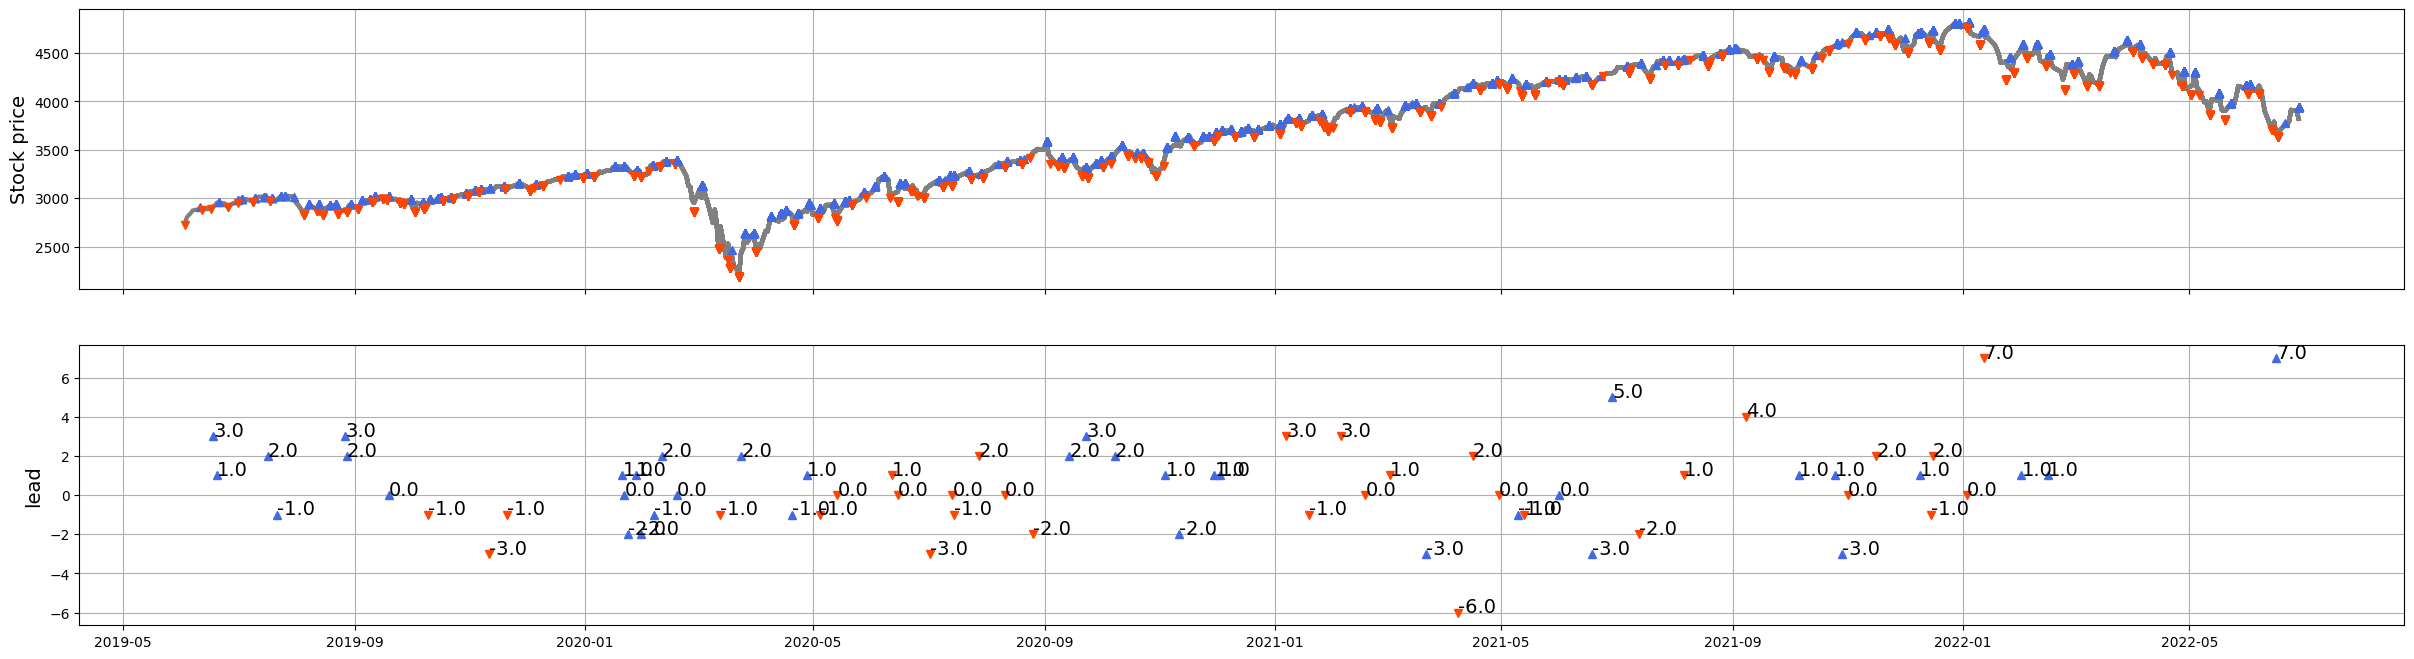

In [28]:
stock_name = "^GSPC"
date_predict_start = '2019-06-01'
data_range = 200
slide_range = 10
n_slide = 70
pv_range = 2
n_harm_lower_limit = 1
n_harm_upper_limit = 70
fit_method = 'rmse'
pv_method = 'HL'
harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error = main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
    n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method)
